In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

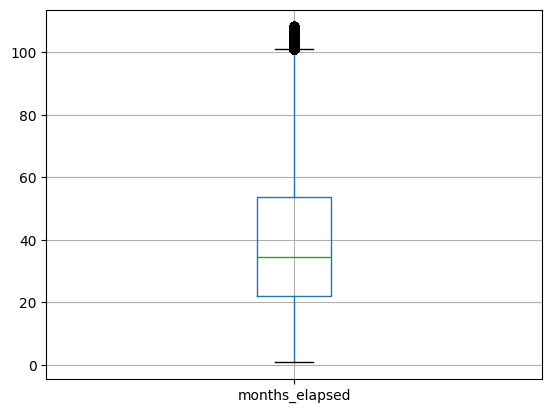

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

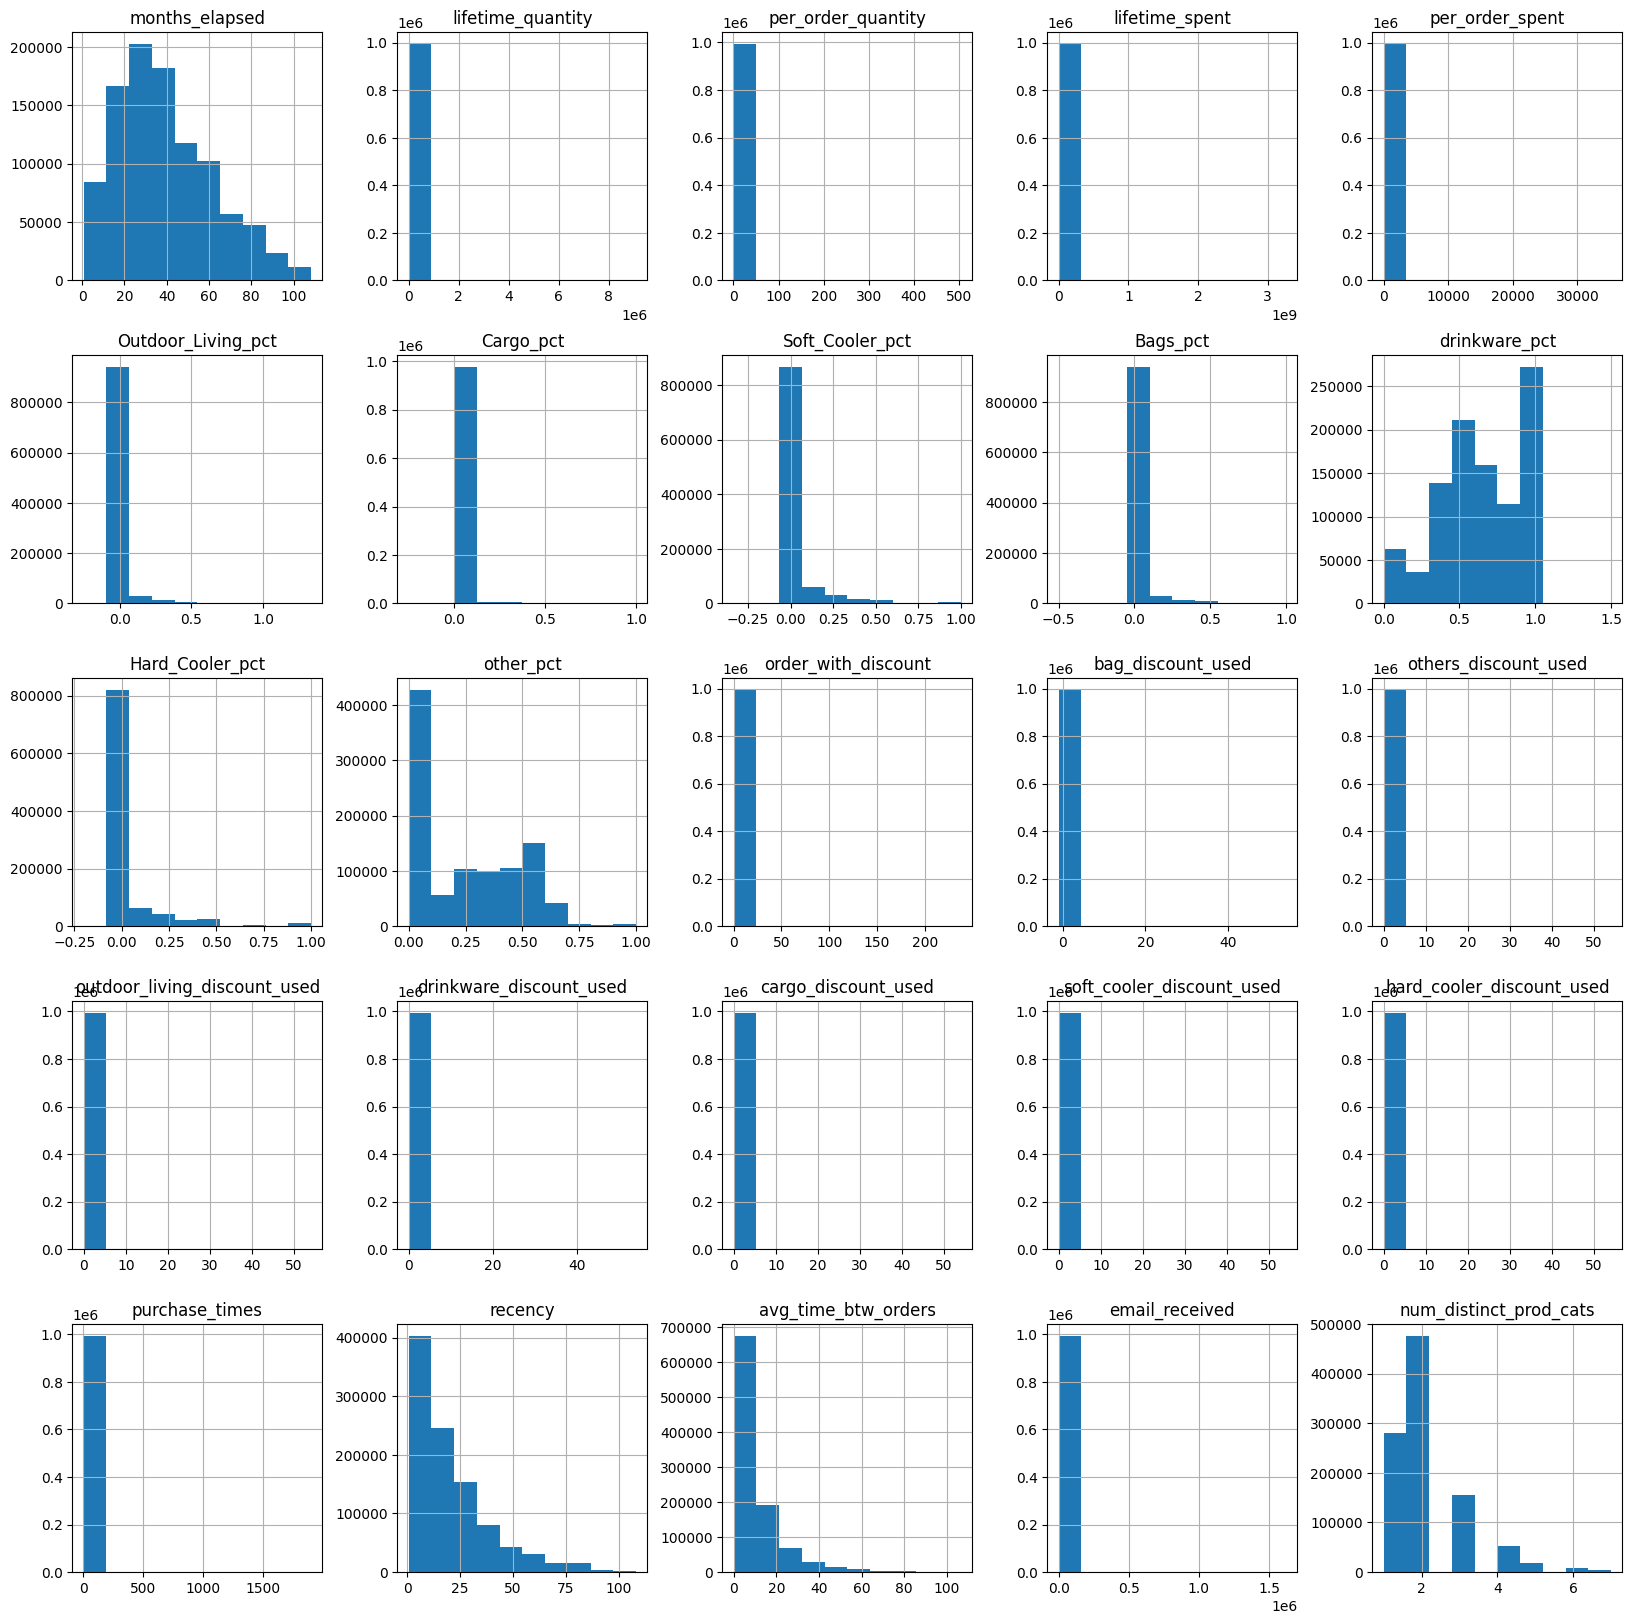

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

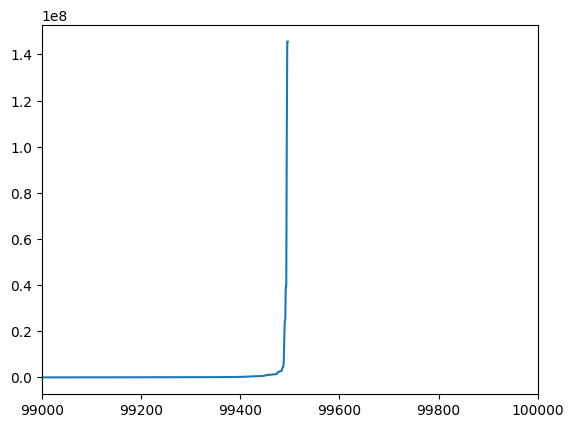

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

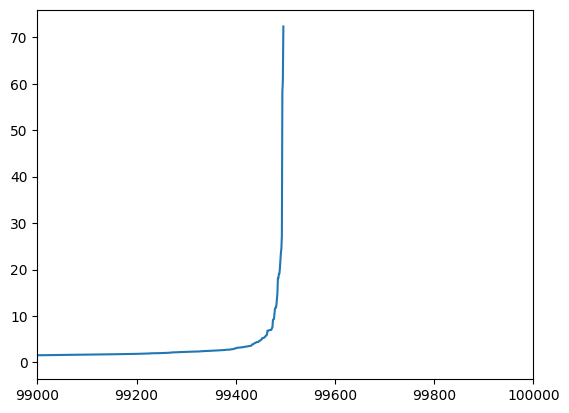

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_merged_2.head()

customer_id  months_elapsed  lifetime_spent  \
0  e75c8f2a-e854-4b5d-b352-01153eabbca1       63.033333          1820.0   
1  eec022da-3335-4923-9f53-b5b2ffb4f951       83.400000        642370.0   
2  d169c27a-4d64-491a-ac64-9704c4076520       64.400000        873022.0   
3  1b5883e9-ce4c-4b5d-a10e-e63b4ddeb733       40.000000       2047134.0   
4  82de77f3-4028-456d-b89b-4866cc365380       70.500000       1250260.0   

   per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0       165.454545                 0.0000    0.00000         0.062500   
1       161.237450                 0.0000    0.00000         0.428571   
2       183.716751                 0.0000    0.00000         0.172414   
3       130.765506                 0.0000    0.00000         0.000000   
4        97.107573                 0.0625    0.03125         0.000000   

   Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  stainless  \
0  0.000000       0.687500         0.000000  ...    0.0      2.0        8.0   
1  0.142857       0.142857         0.000000  ...    0.0      0.0        1.0   
2  0.000000       0.724138         0.103448  ...    8.0      1.0        1.0   
3  0.000000       0.387097         0.032258  ...    NaN      NaN        NaN   
4  0.062500       0.125000         0.156250  ...    NaN      NaN        NaN   

   charcoal  nordic_purple  harvest_red  alpine_yellow  other_color  \
0       1.0            0.0          0.0            0.0          5.0   
1       2.0            0.0          0.0            0.0          4.0   
2       2.0            0.0          0.0            0.0         13.0   
3       NaN            NaN          NaN            NaN          NaN   
4       NaN            NaN          NaN            NaN          NaN   

   lifetime_quantity  per_order_quantity  
0                NaN                 NaN  
1                8.0            2.666667  
2               29.0            2.900000  
3               31.0            6.200000  
4                NaN                 NaN  

[5 rows x 32 columns]

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

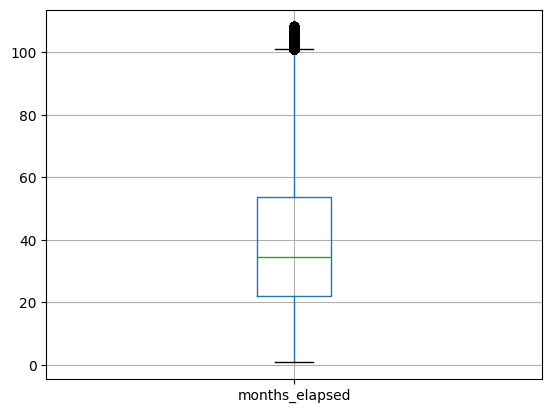

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

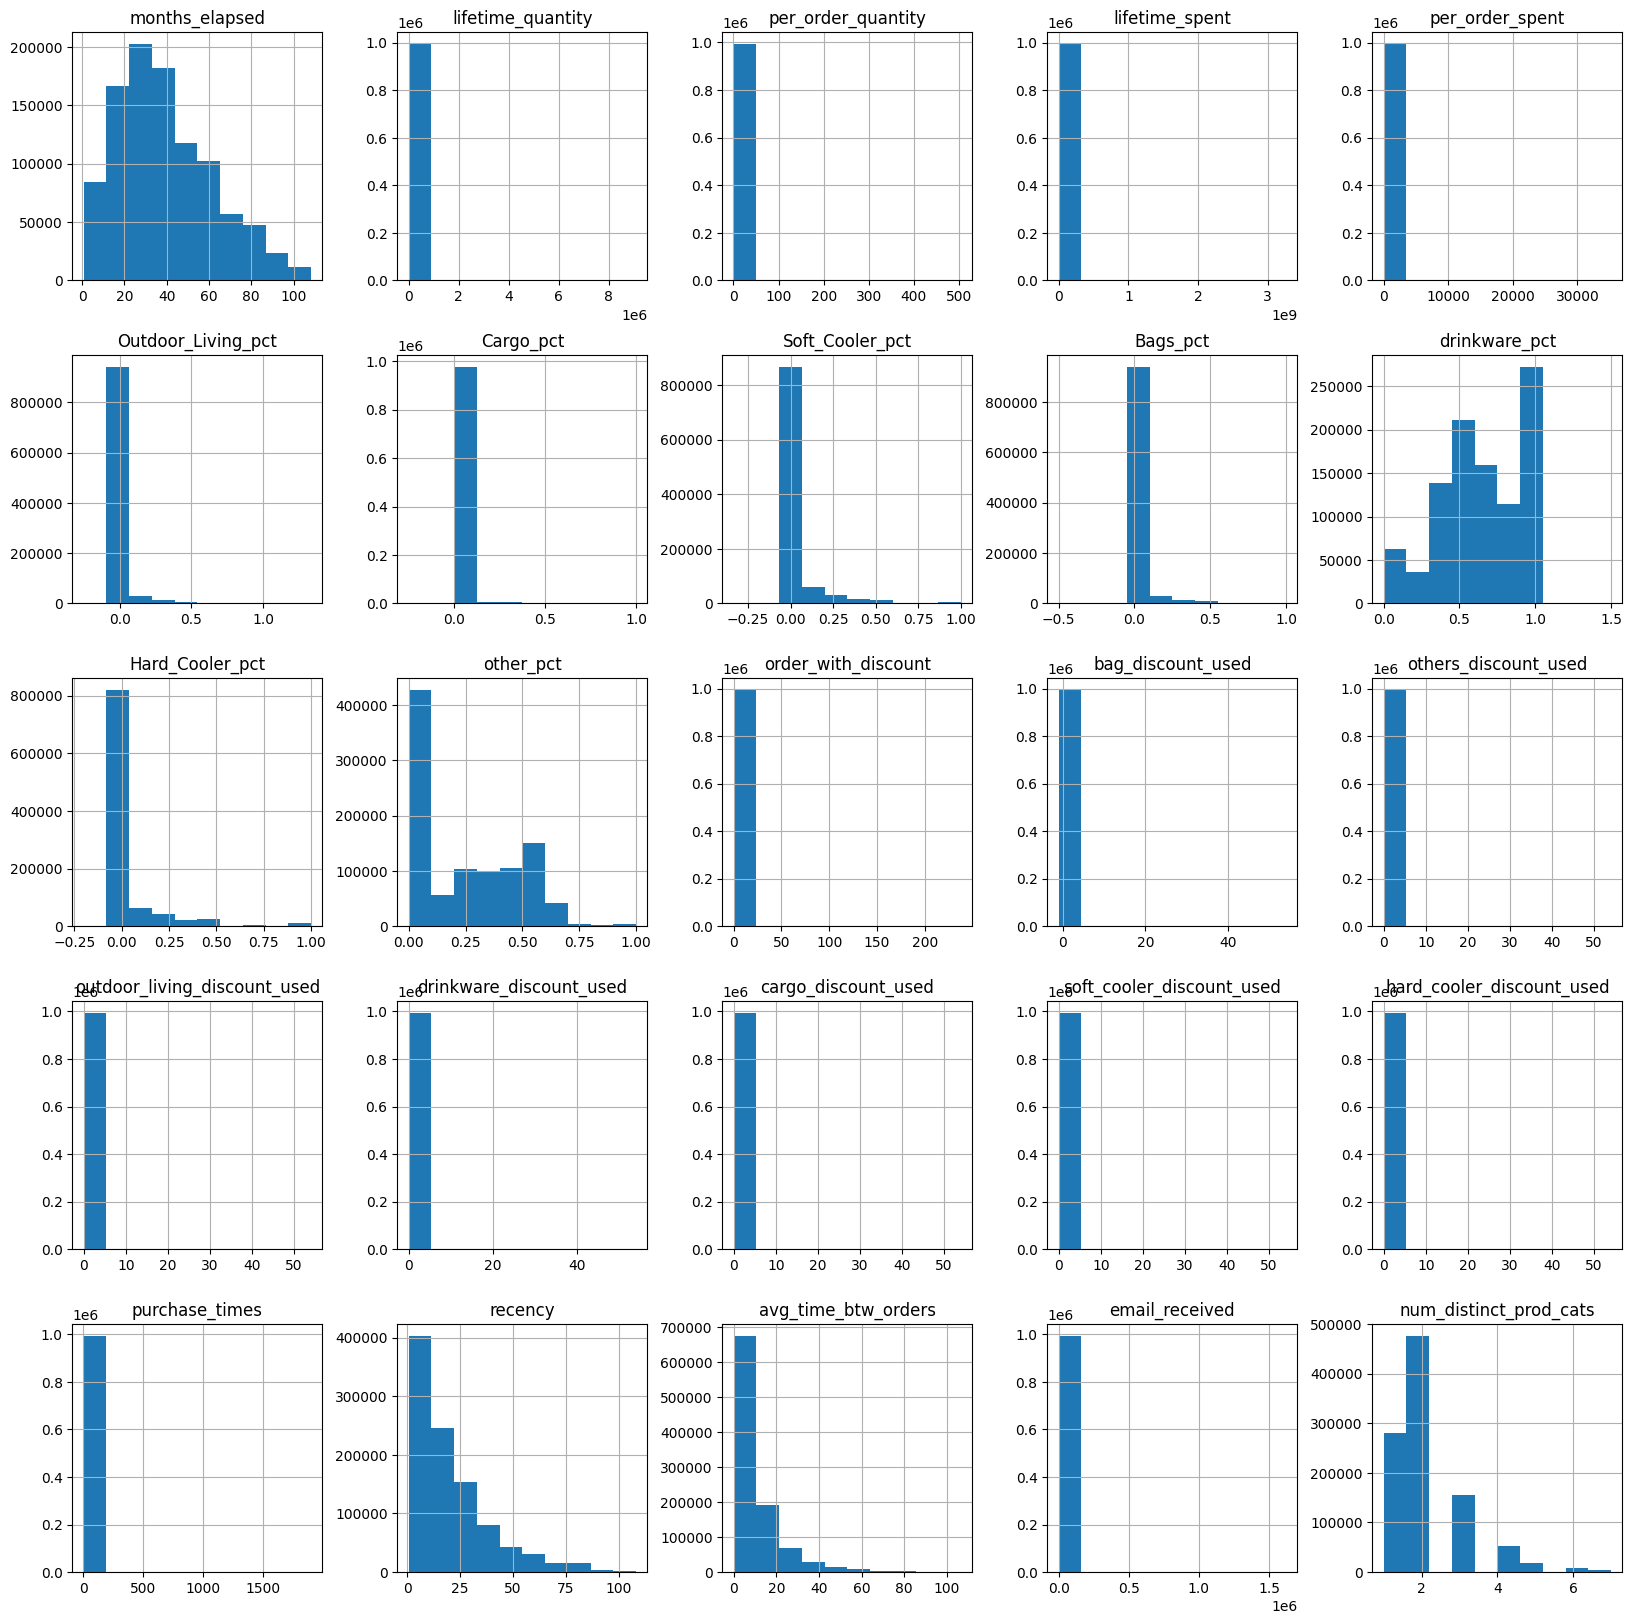

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

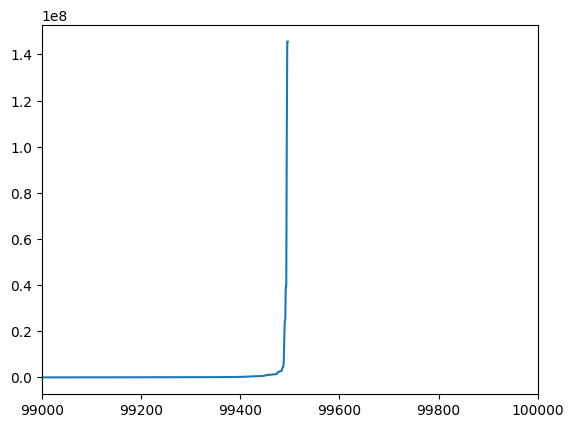

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

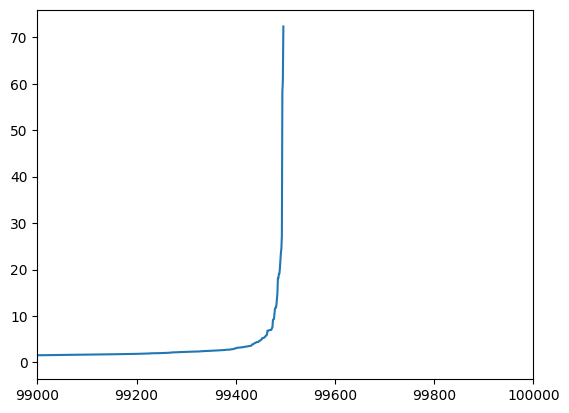

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

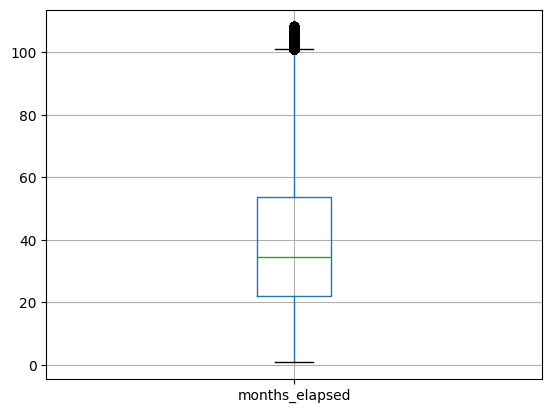

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

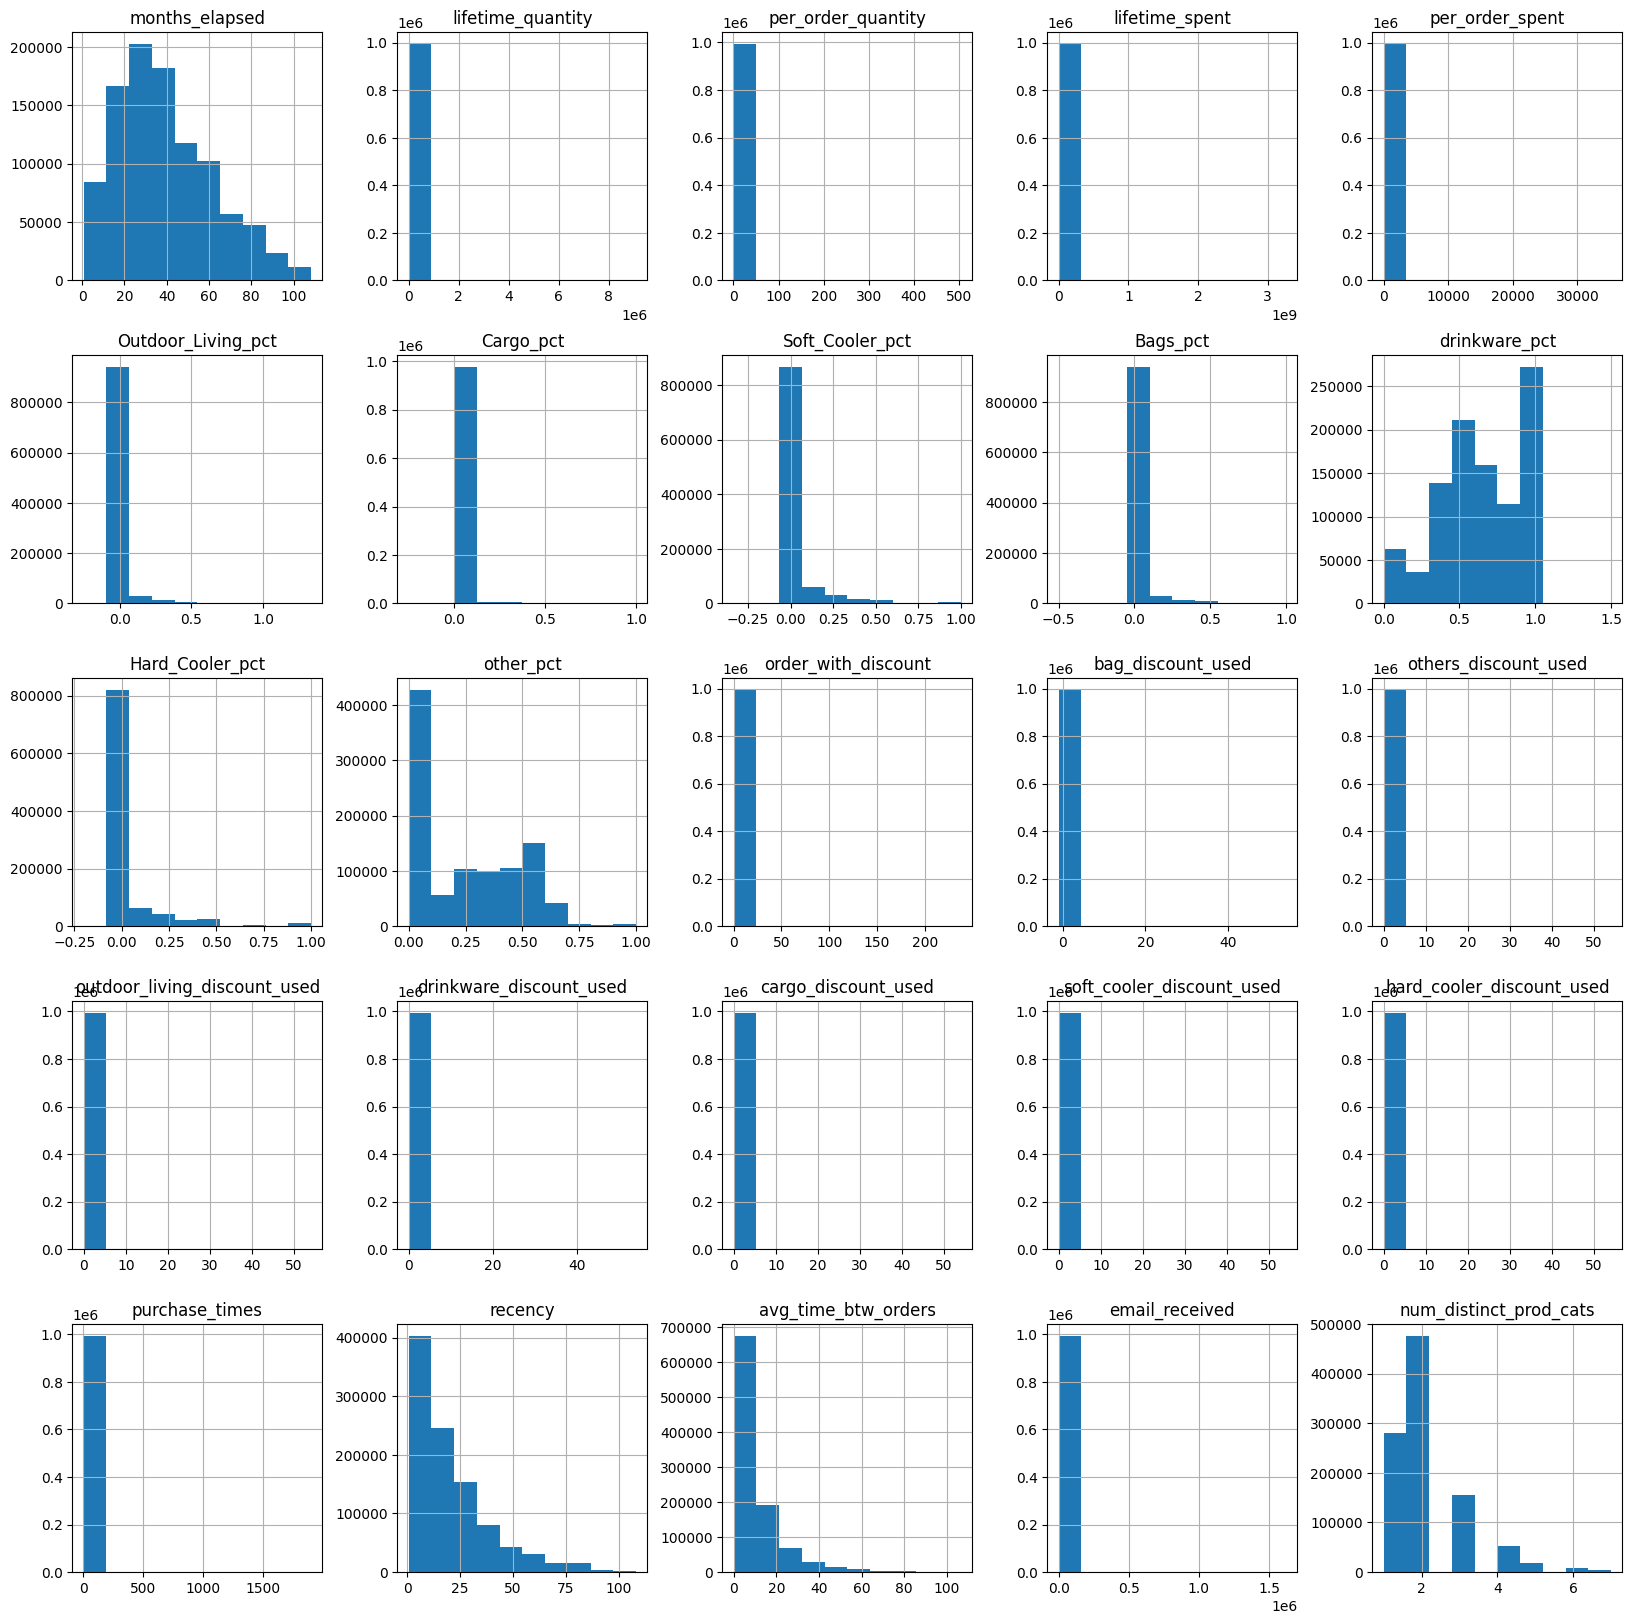

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

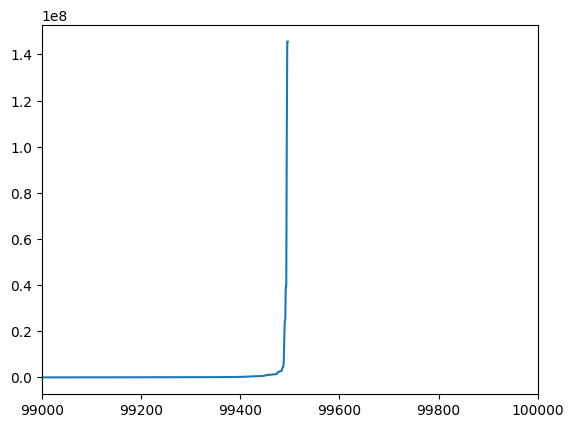

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

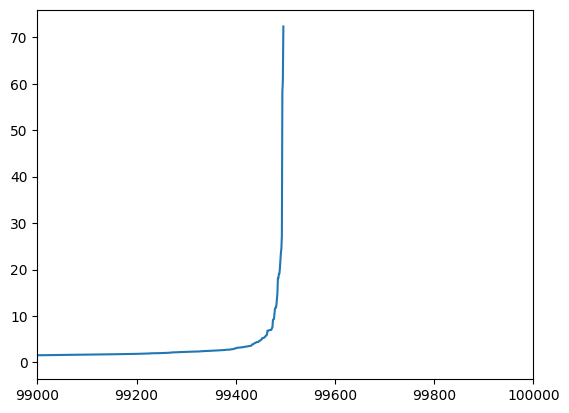

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

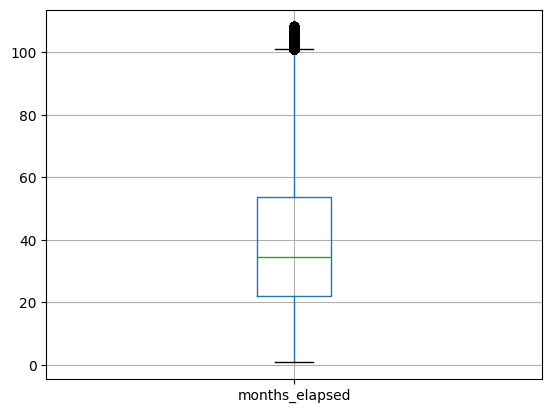

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

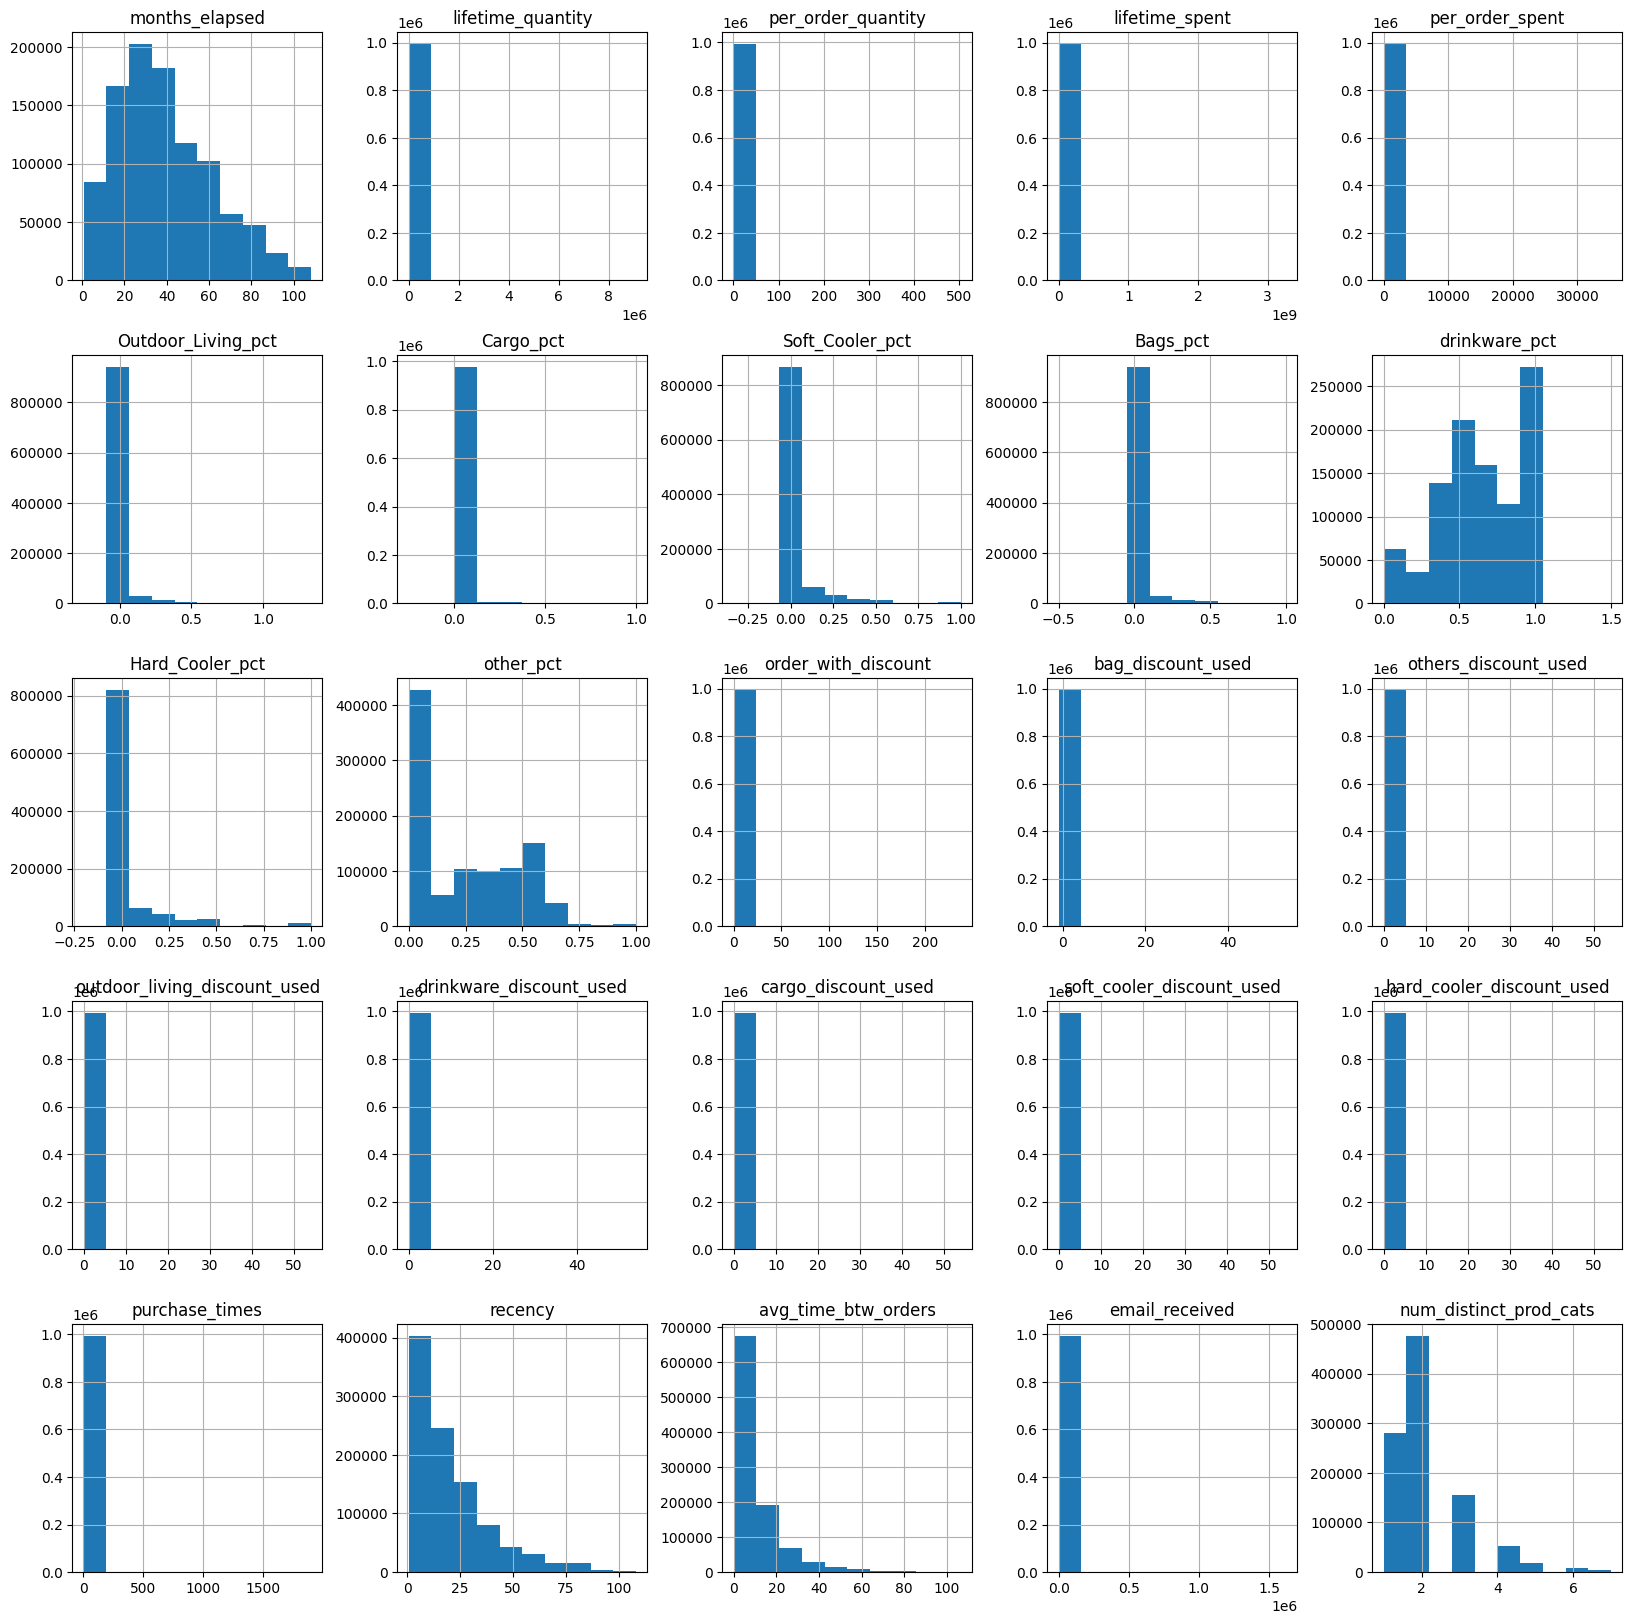

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

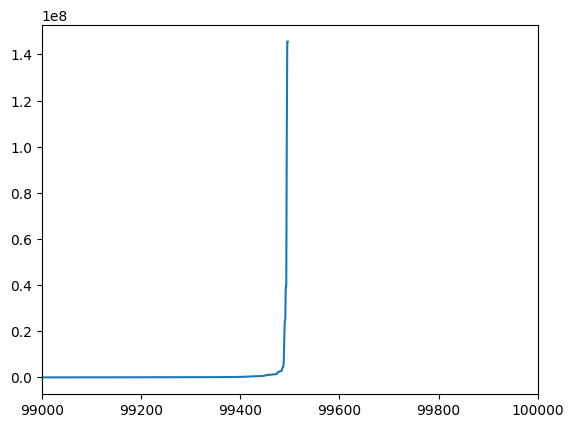

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

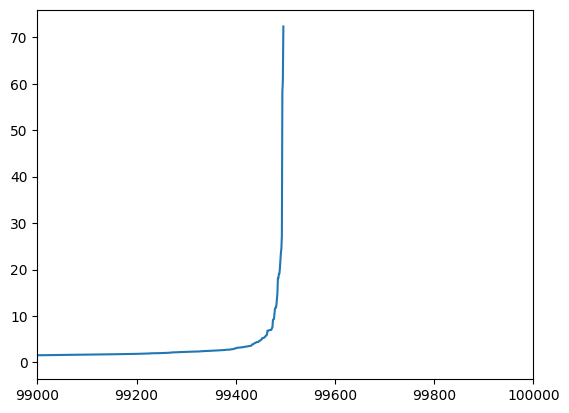

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_merged_2.head()

customer_id  months_elapsed  lifetime_spent  \
0  e75c8f2a-e854-4b5d-b352-01153eabbca1       63.033333          1820.0   
1  eec022da-3335-4923-9f53-b5b2ffb4f951       83.400000        642370.0   
2  d169c27a-4d64-491a-ac64-9704c4076520       64.400000        873022.0   
3  1b5883e9-ce4c-4b5d-a10e-e63b4ddeb733       40.000000       2047134.0   
4  82de77f3-4028-456d-b89b-4866cc365380       70.500000       1250260.0   

   per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0       165.454545                 0.0000    0.00000         0.062500   
1       161.237450                 0.0000    0.00000         0.428571   
2       183.716751                 0.0000    0.00000         0.172414   
3       130.765506                 0.0000    0.00000         0.000000   
4        97.107573                 0.0625    0.03125         0.000000   

   Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  stainless  \
0  0.000000       0.687500         0.000000  ...    0.0      2.0        8.0   
1  0.142857       0.142857         0.000000  ...    0.0      0.0        1.0   
2  0.000000       0.724138         0.103448  ...    8.0      1.0        1.0   
3  0.000000       0.387097         0.032258  ...    NaN      NaN        NaN   
4  0.062500       0.125000         0.156250  ...    NaN      NaN        NaN   

   charcoal  nordic_purple  harvest_red  alpine_yellow  other_color  \
0       1.0            0.0          0.0            0.0          5.0   
1       2.0            0.0          0.0            0.0          4.0   
2       2.0            0.0          0.0            0.0         13.0   
3       NaN            NaN          NaN            NaN          NaN   
4       NaN            NaN          NaN            NaN          NaN   

   lifetime_quantity  per_order_quantity  
0                NaN                 NaN  
1                8.0            2.666667  
2               29.0            2.900000  
3               31.0            6.200000  
4                NaN                 NaN  

[5 rows x 32 columns]

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

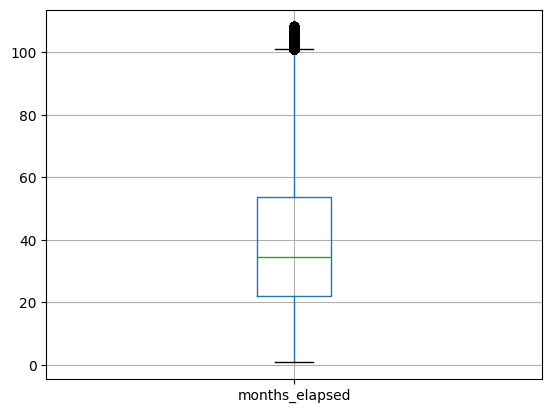

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

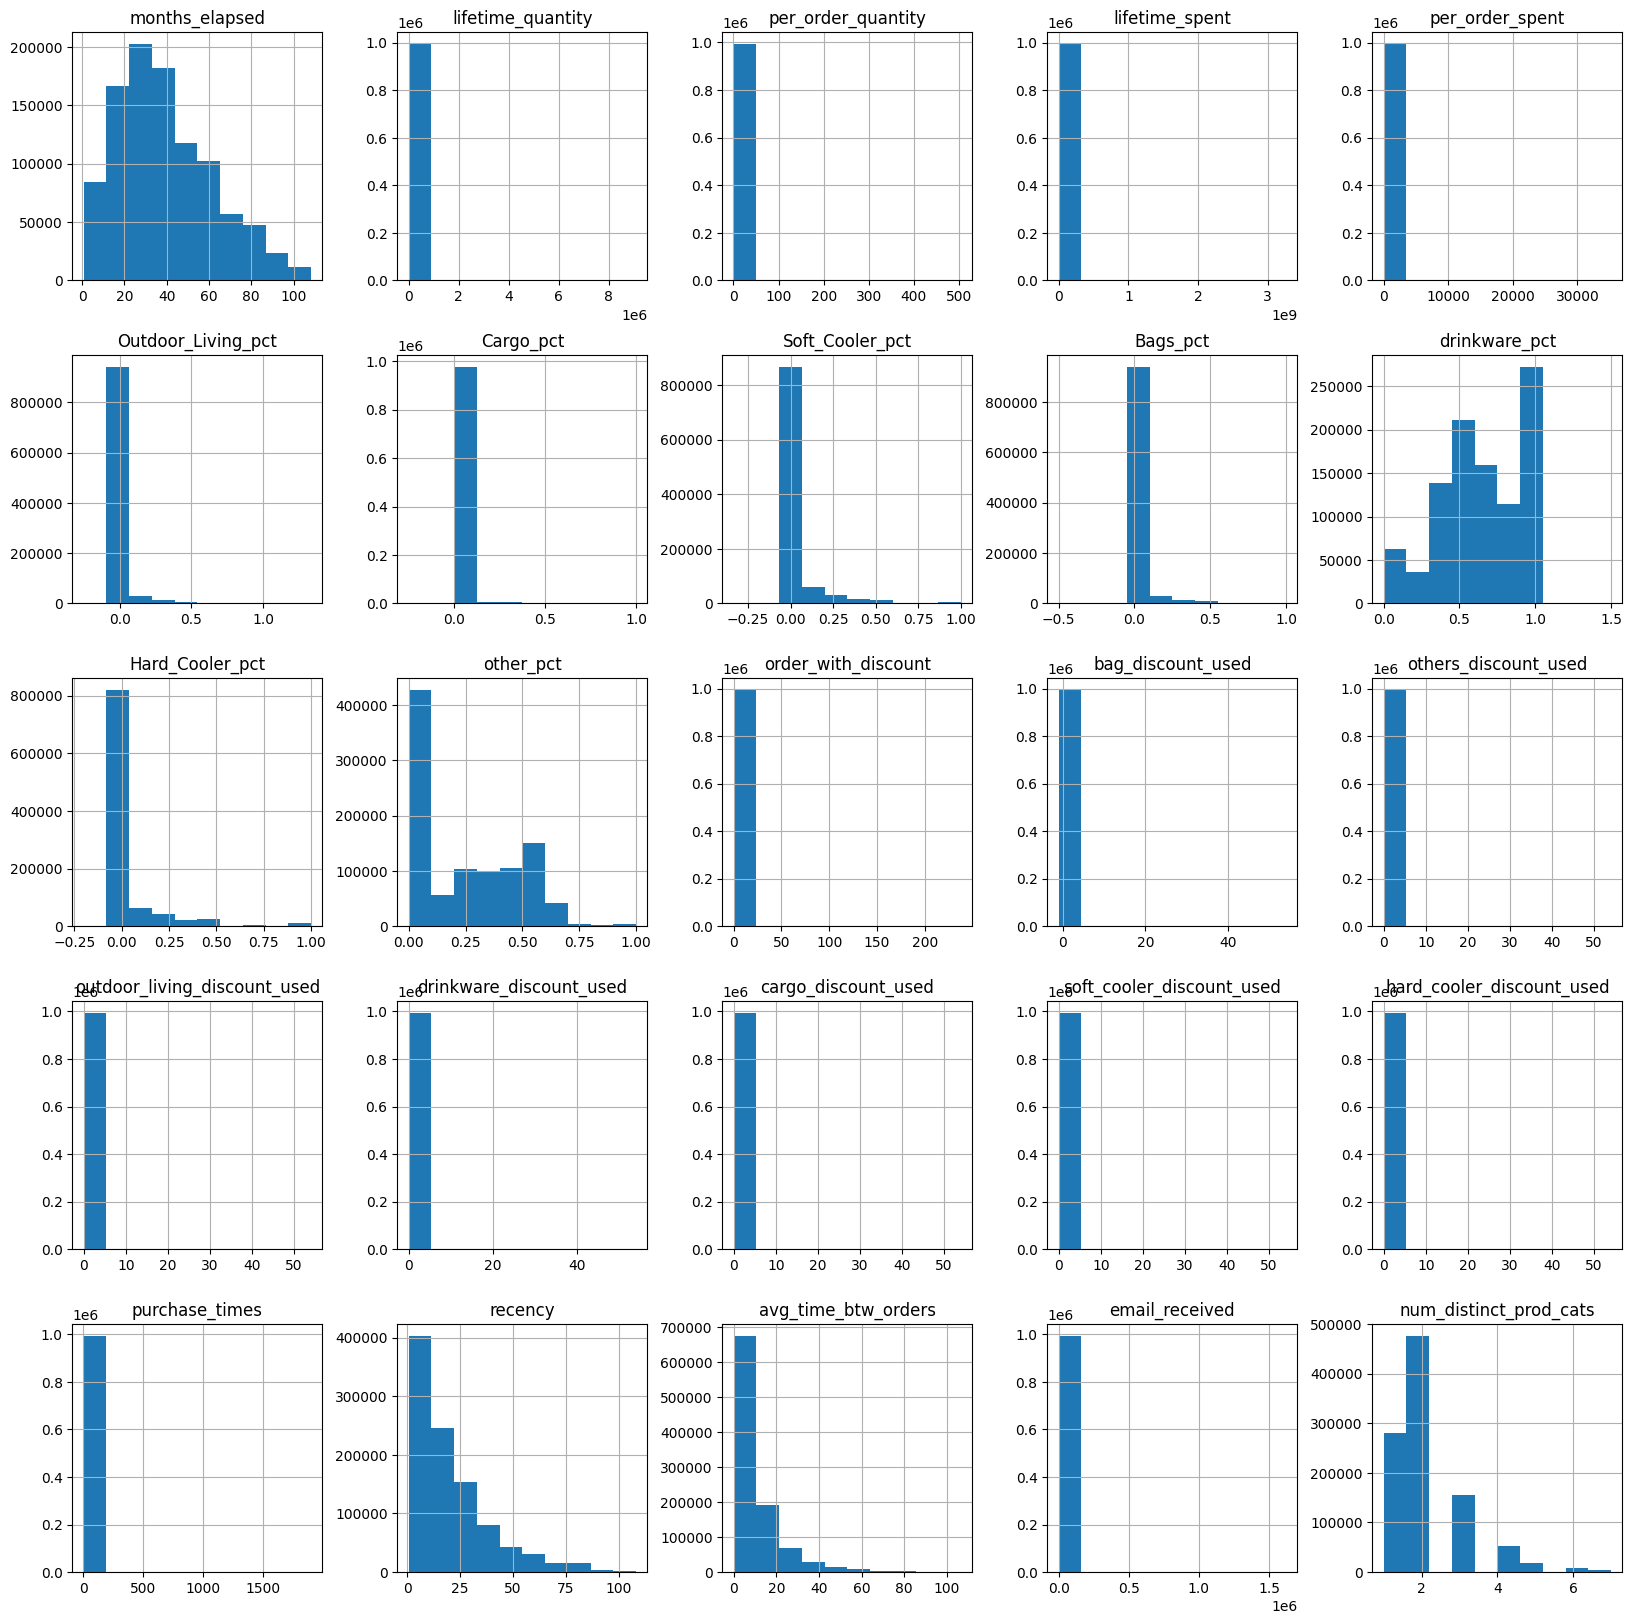

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

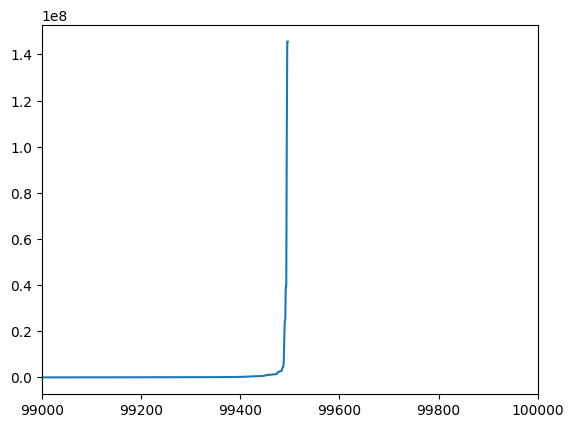

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

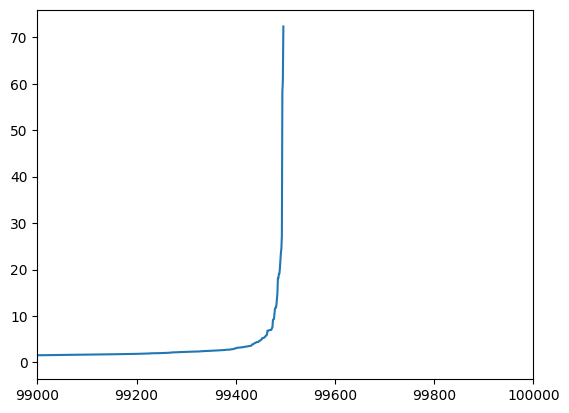

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

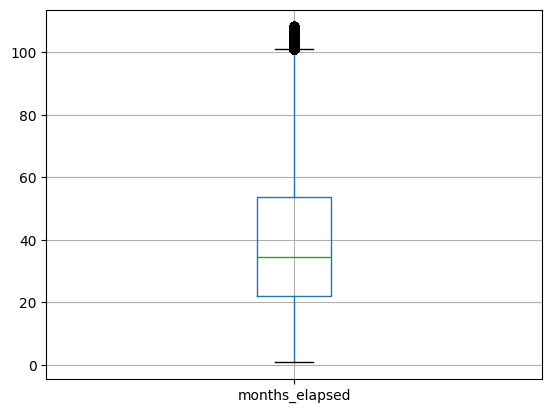

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

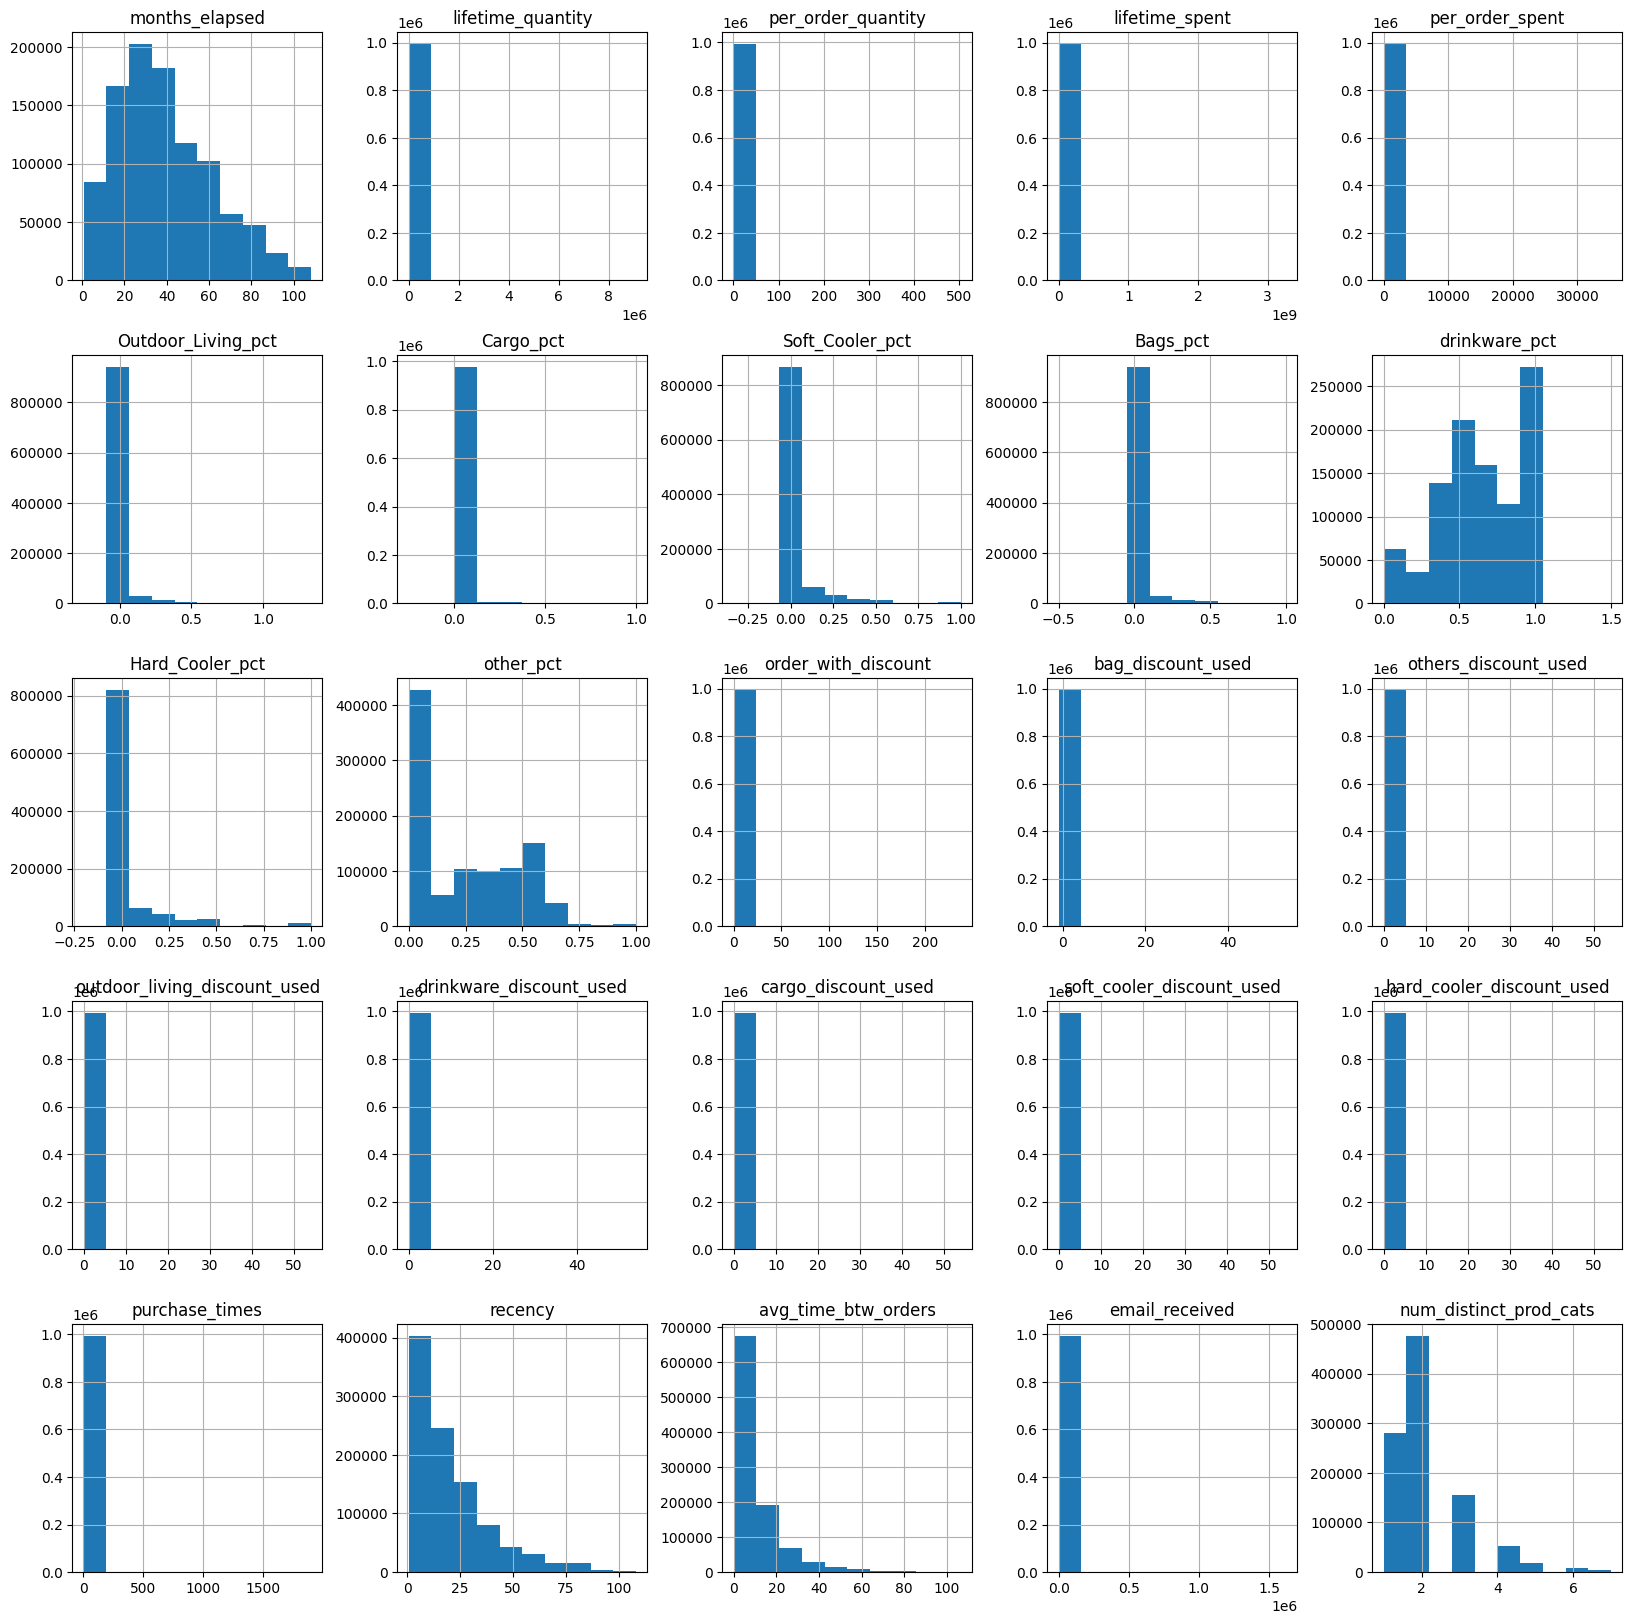

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

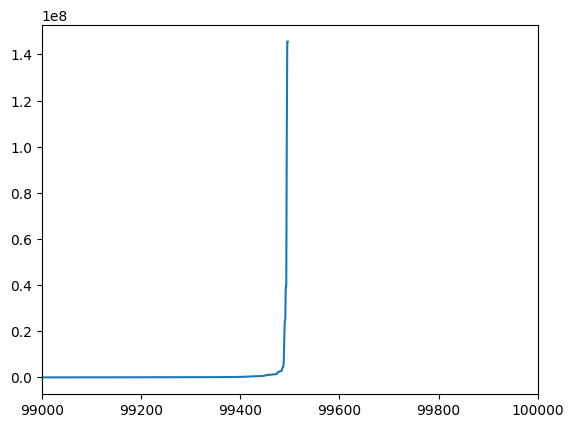

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

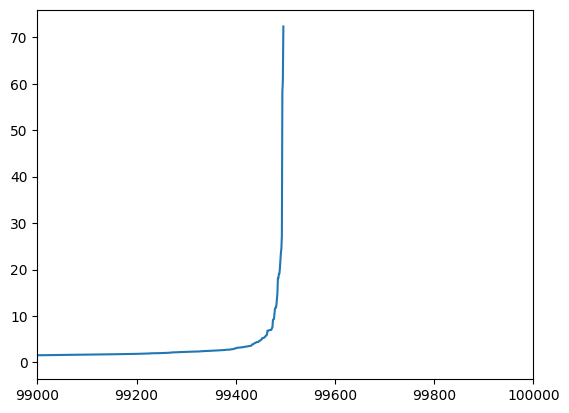

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
data = p

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

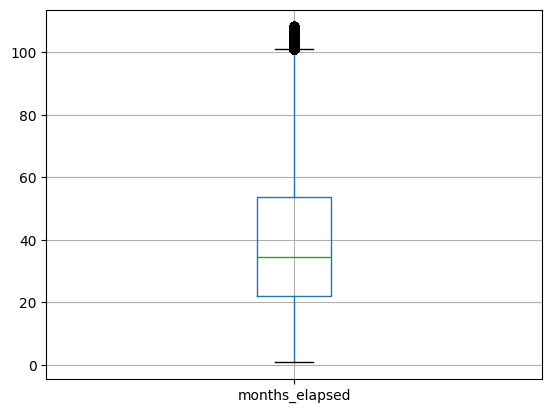

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

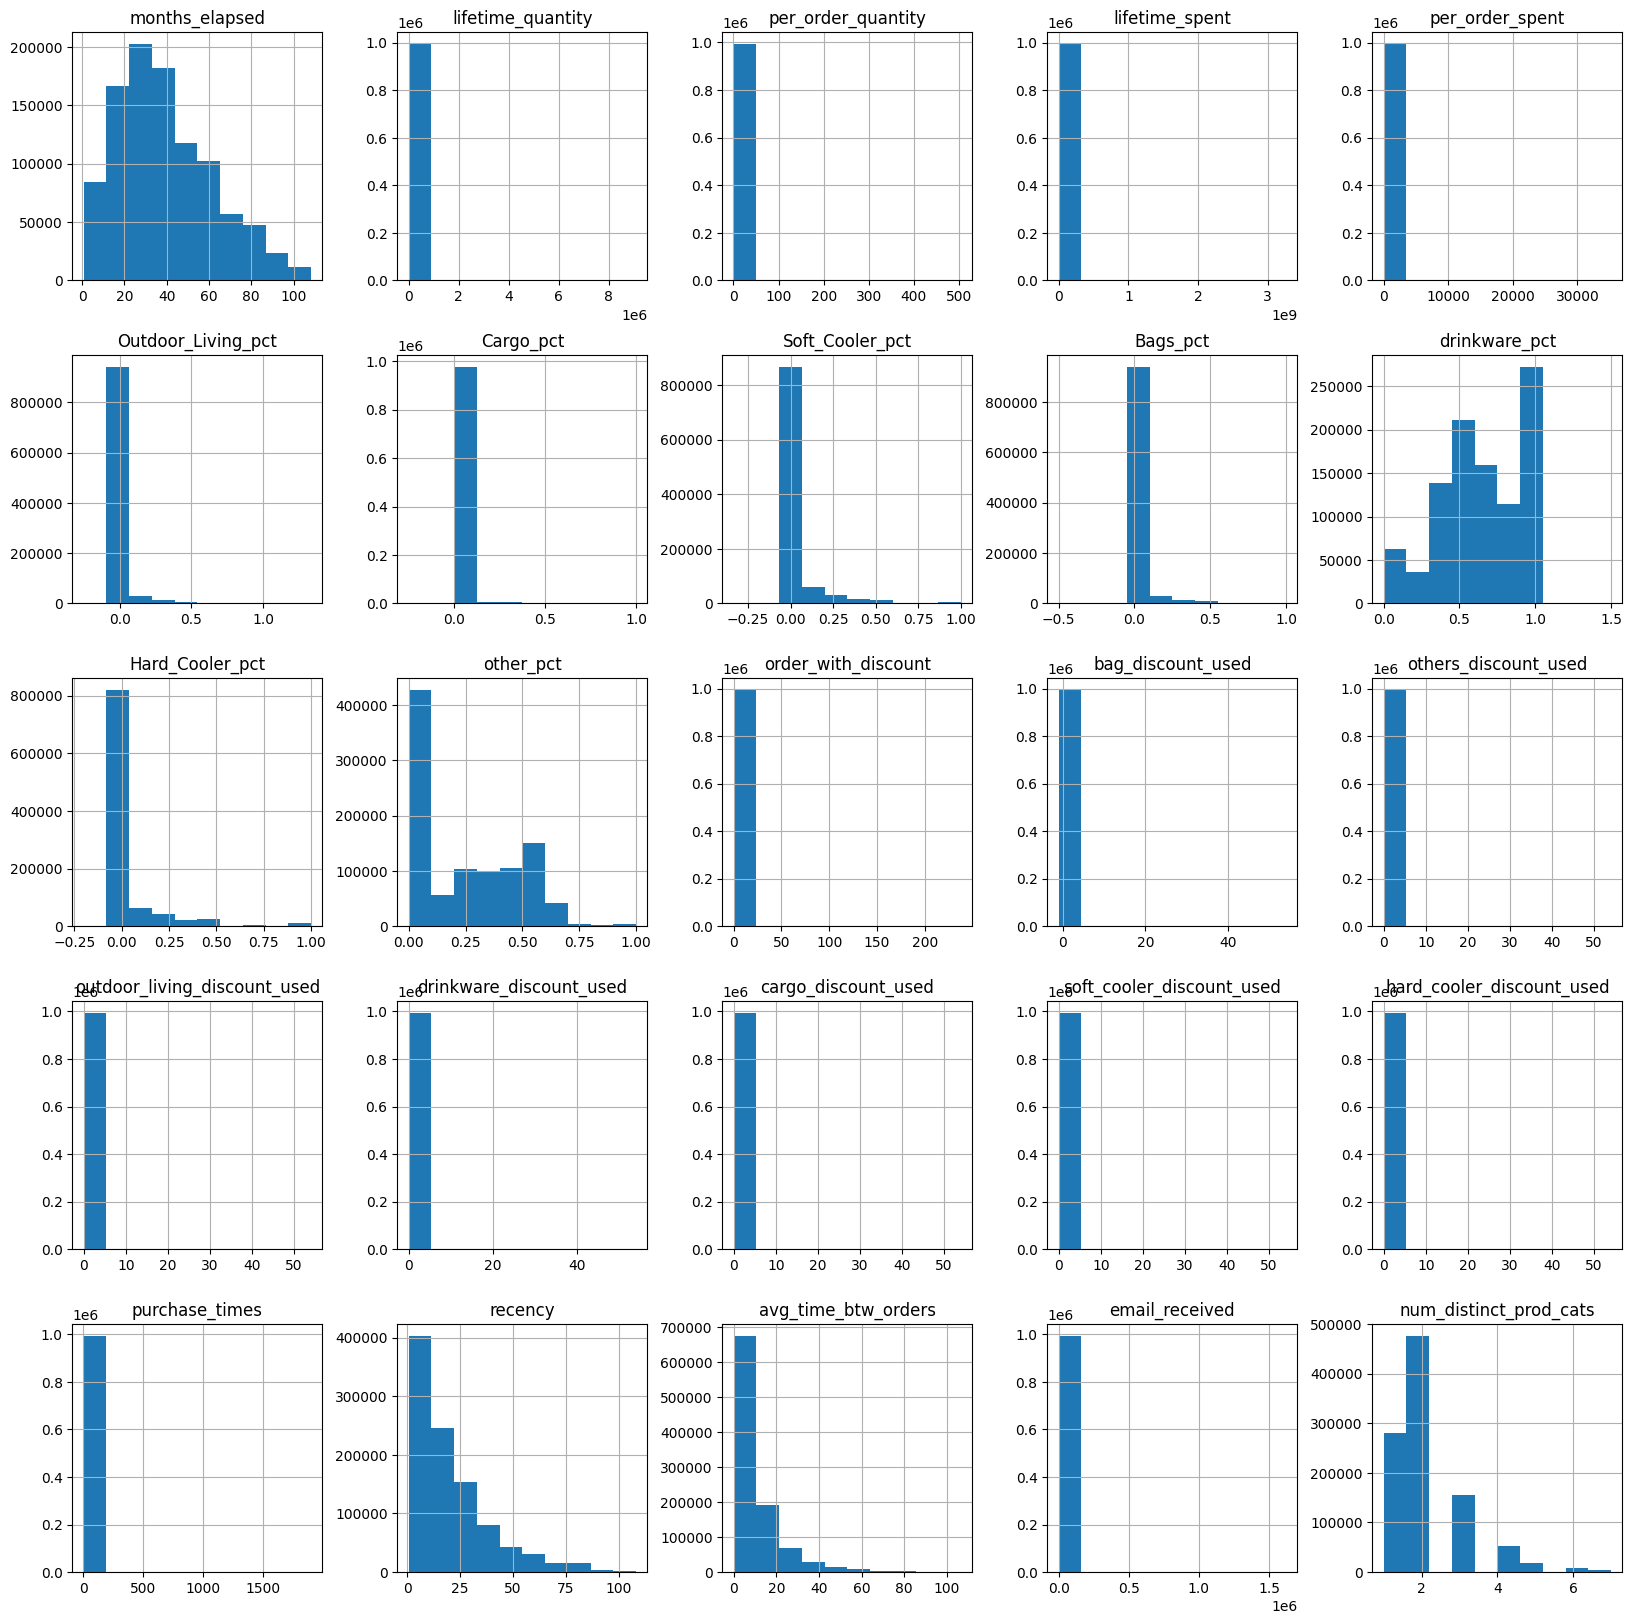

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

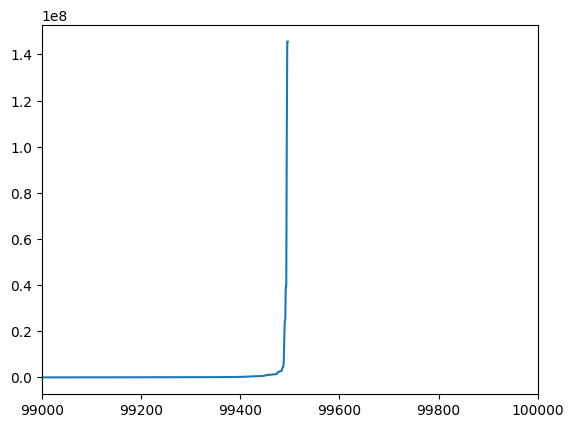

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

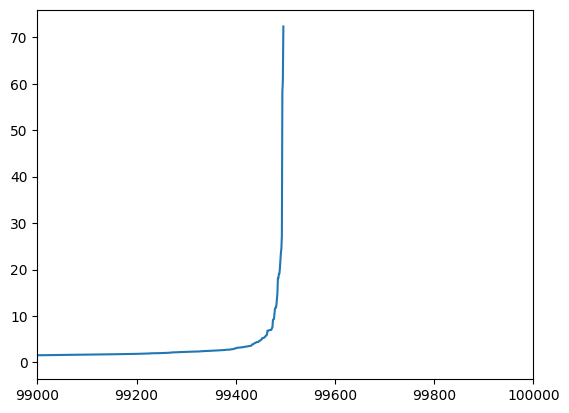

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_merged_2.head()

customer_id  months_elapsed  lifetime_spent  \
0  e75c8f2a-e854-4b5d-b352-01153eabbca1       63.033333          1820.0   
1  eec022da-3335-4923-9f53-b5b2ffb4f951       83.400000        642370.0   
2  d169c27a-4d64-491a-ac64-9704c4076520       64.400000        873022.0   
3  1b5883e9-ce4c-4b5d-a10e-e63b4ddeb733       40.000000       2047134.0   
4  82de77f3-4028-456d-b89b-4866cc365380       70.500000       1250260.0   

   per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0       165.454545                 0.0000    0.00000         0.062500   
1       161.237450                 0.0000    0.00000         0.428571   
2       183.716751                 0.0000    0.00000         0.172414   
3       130.765506                 0.0000    0.00000         0.000000   
4        97.107573                 0.0625    0.03125         0.000000   

   Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  stainless  \
0  0.000000       0.687500         0.000000  ...    0.0      2.0        8.0   
1  0.142857       0.142857         0.000000  ...    0.0      0.0        1.0   
2  0.000000       0.724138         0.103448  ...    8.0      1.0        1.0   
3  0.000000       0.387097         0.032258  ...    NaN      NaN        NaN   
4  0.062500       0.125000         0.156250  ...    NaN      NaN        NaN   

   charcoal  nordic_purple  harvest_red  alpine_yellow  other_color  \
0       1.0            0.0          0.0            0.0          5.0   
1       2.0            0.0          0.0            0.0          4.0   
2       2.0            0.0          0.0            0.0         13.0   
3       NaN            NaN          NaN            NaN          NaN   
4       NaN            NaN          NaN            NaN          NaN   

   lifetime_quantity  per_order_quantity  
0                NaN                 NaN  
1                8.0            2.666667  
2               29.0            2.900000  
3               31.0            6.200000  
4                NaN                 NaN  

[5 rows x 32 columns]

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

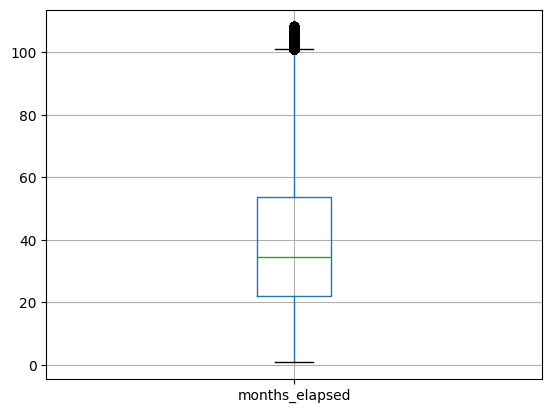

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

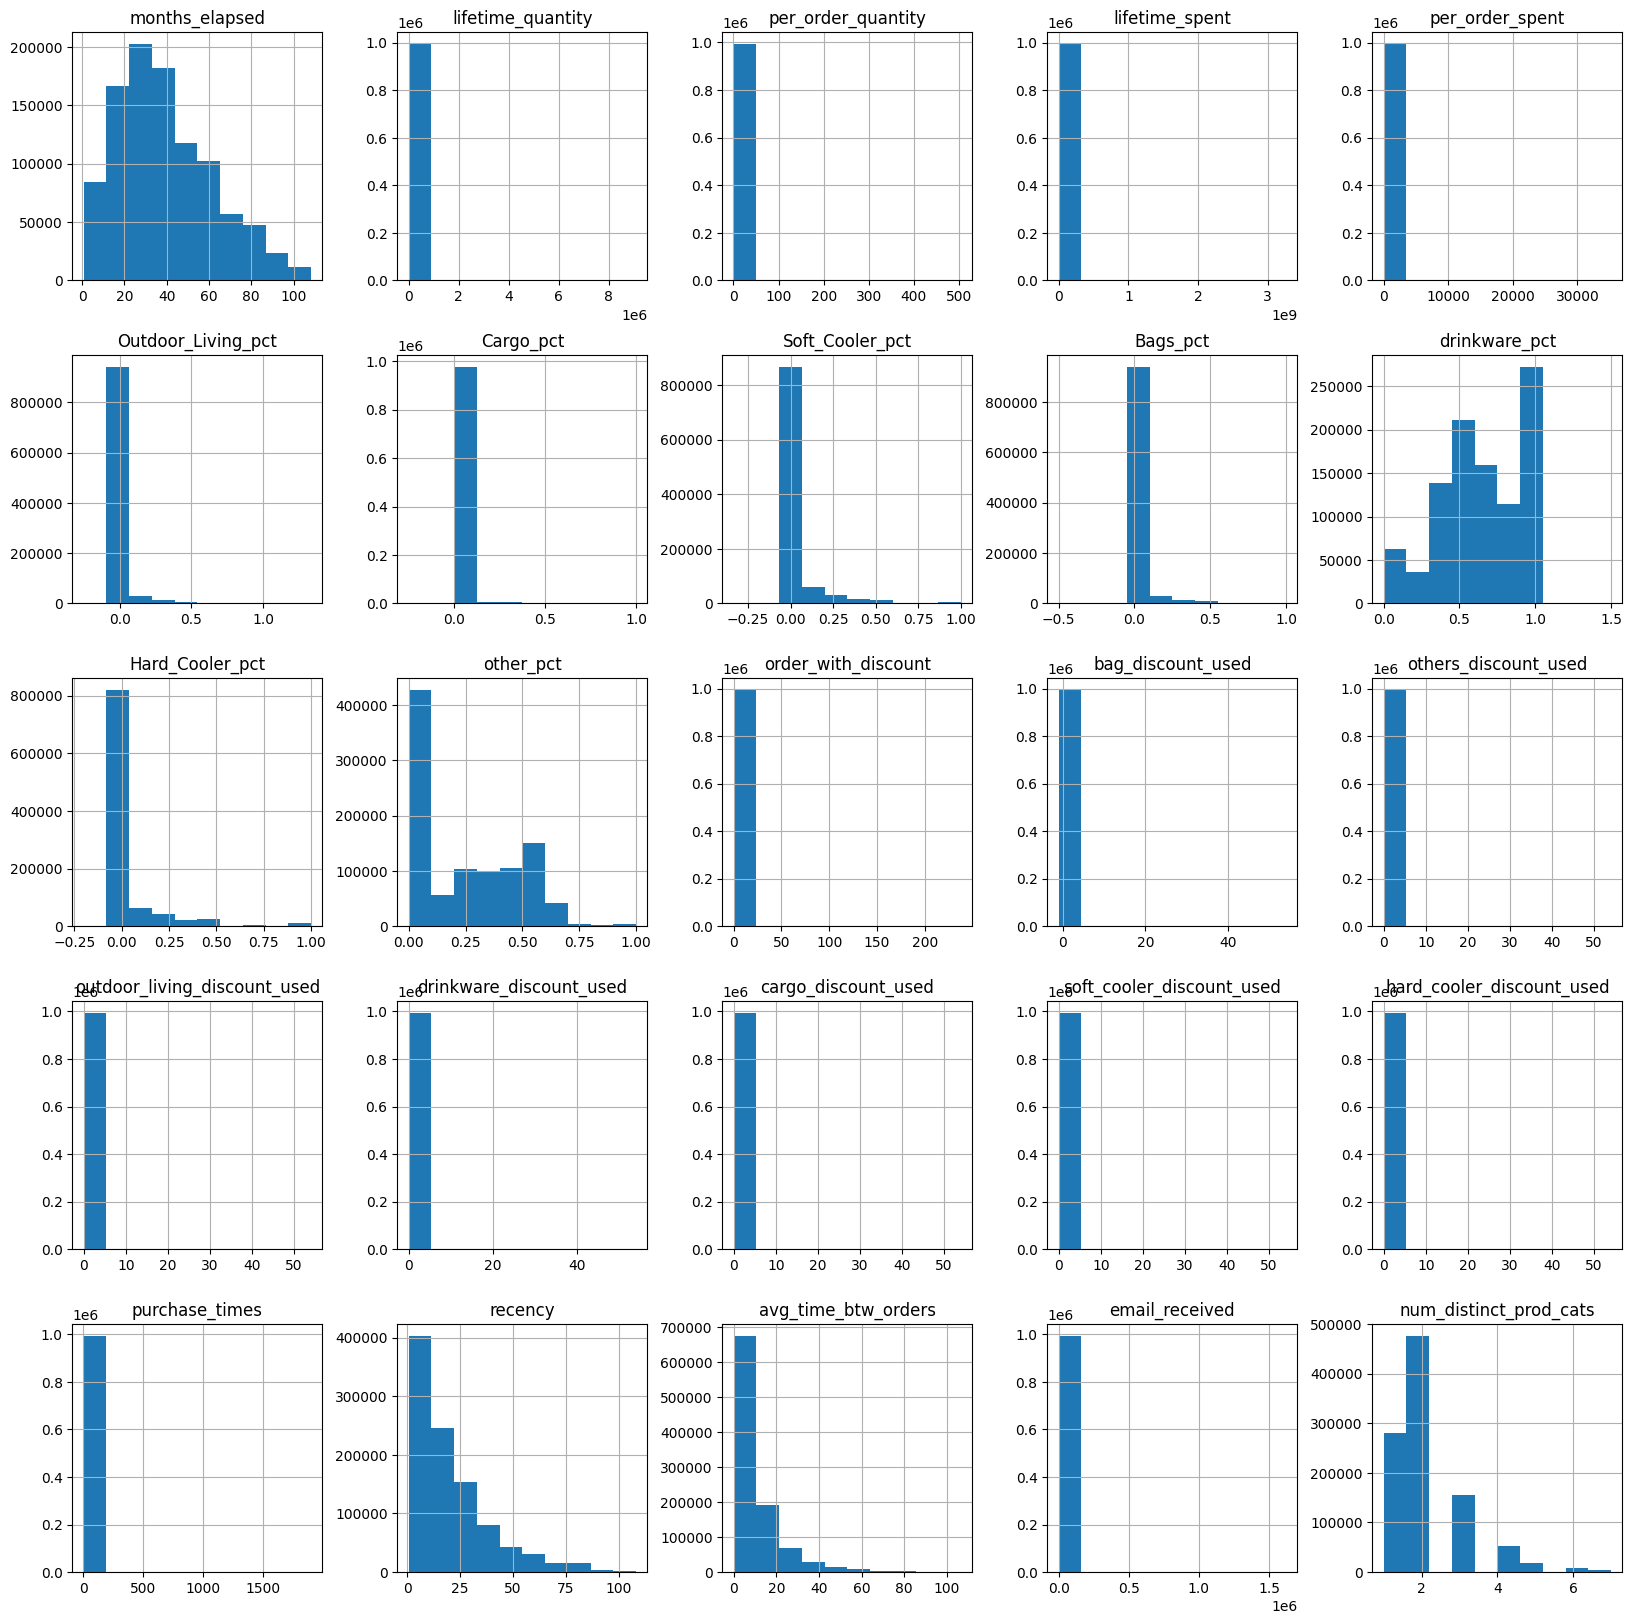

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

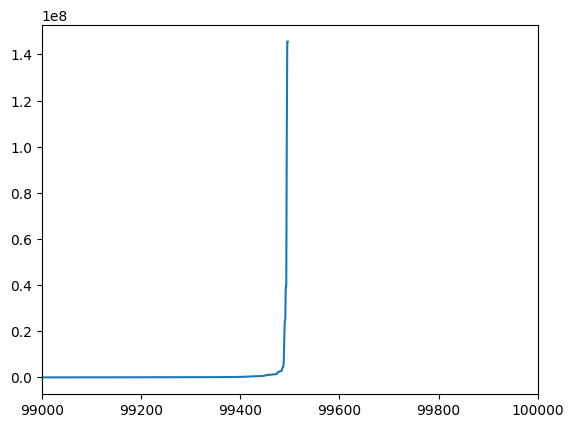

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

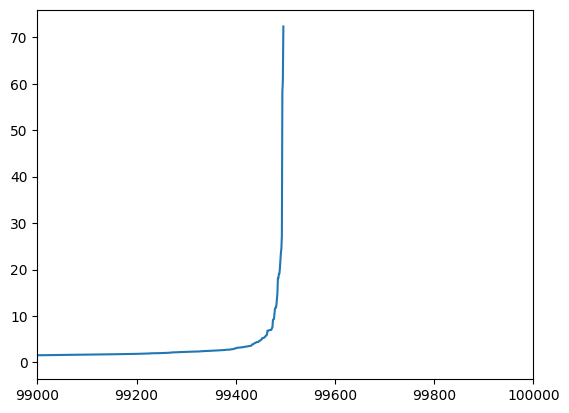

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

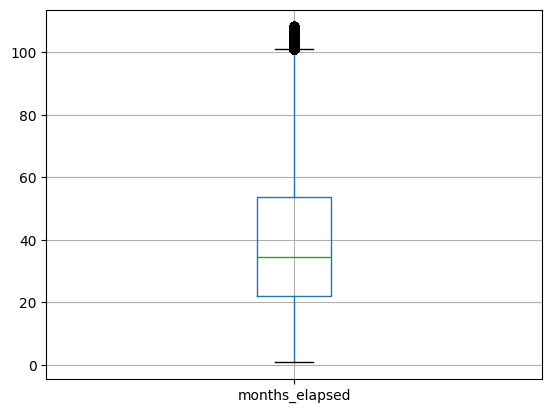

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

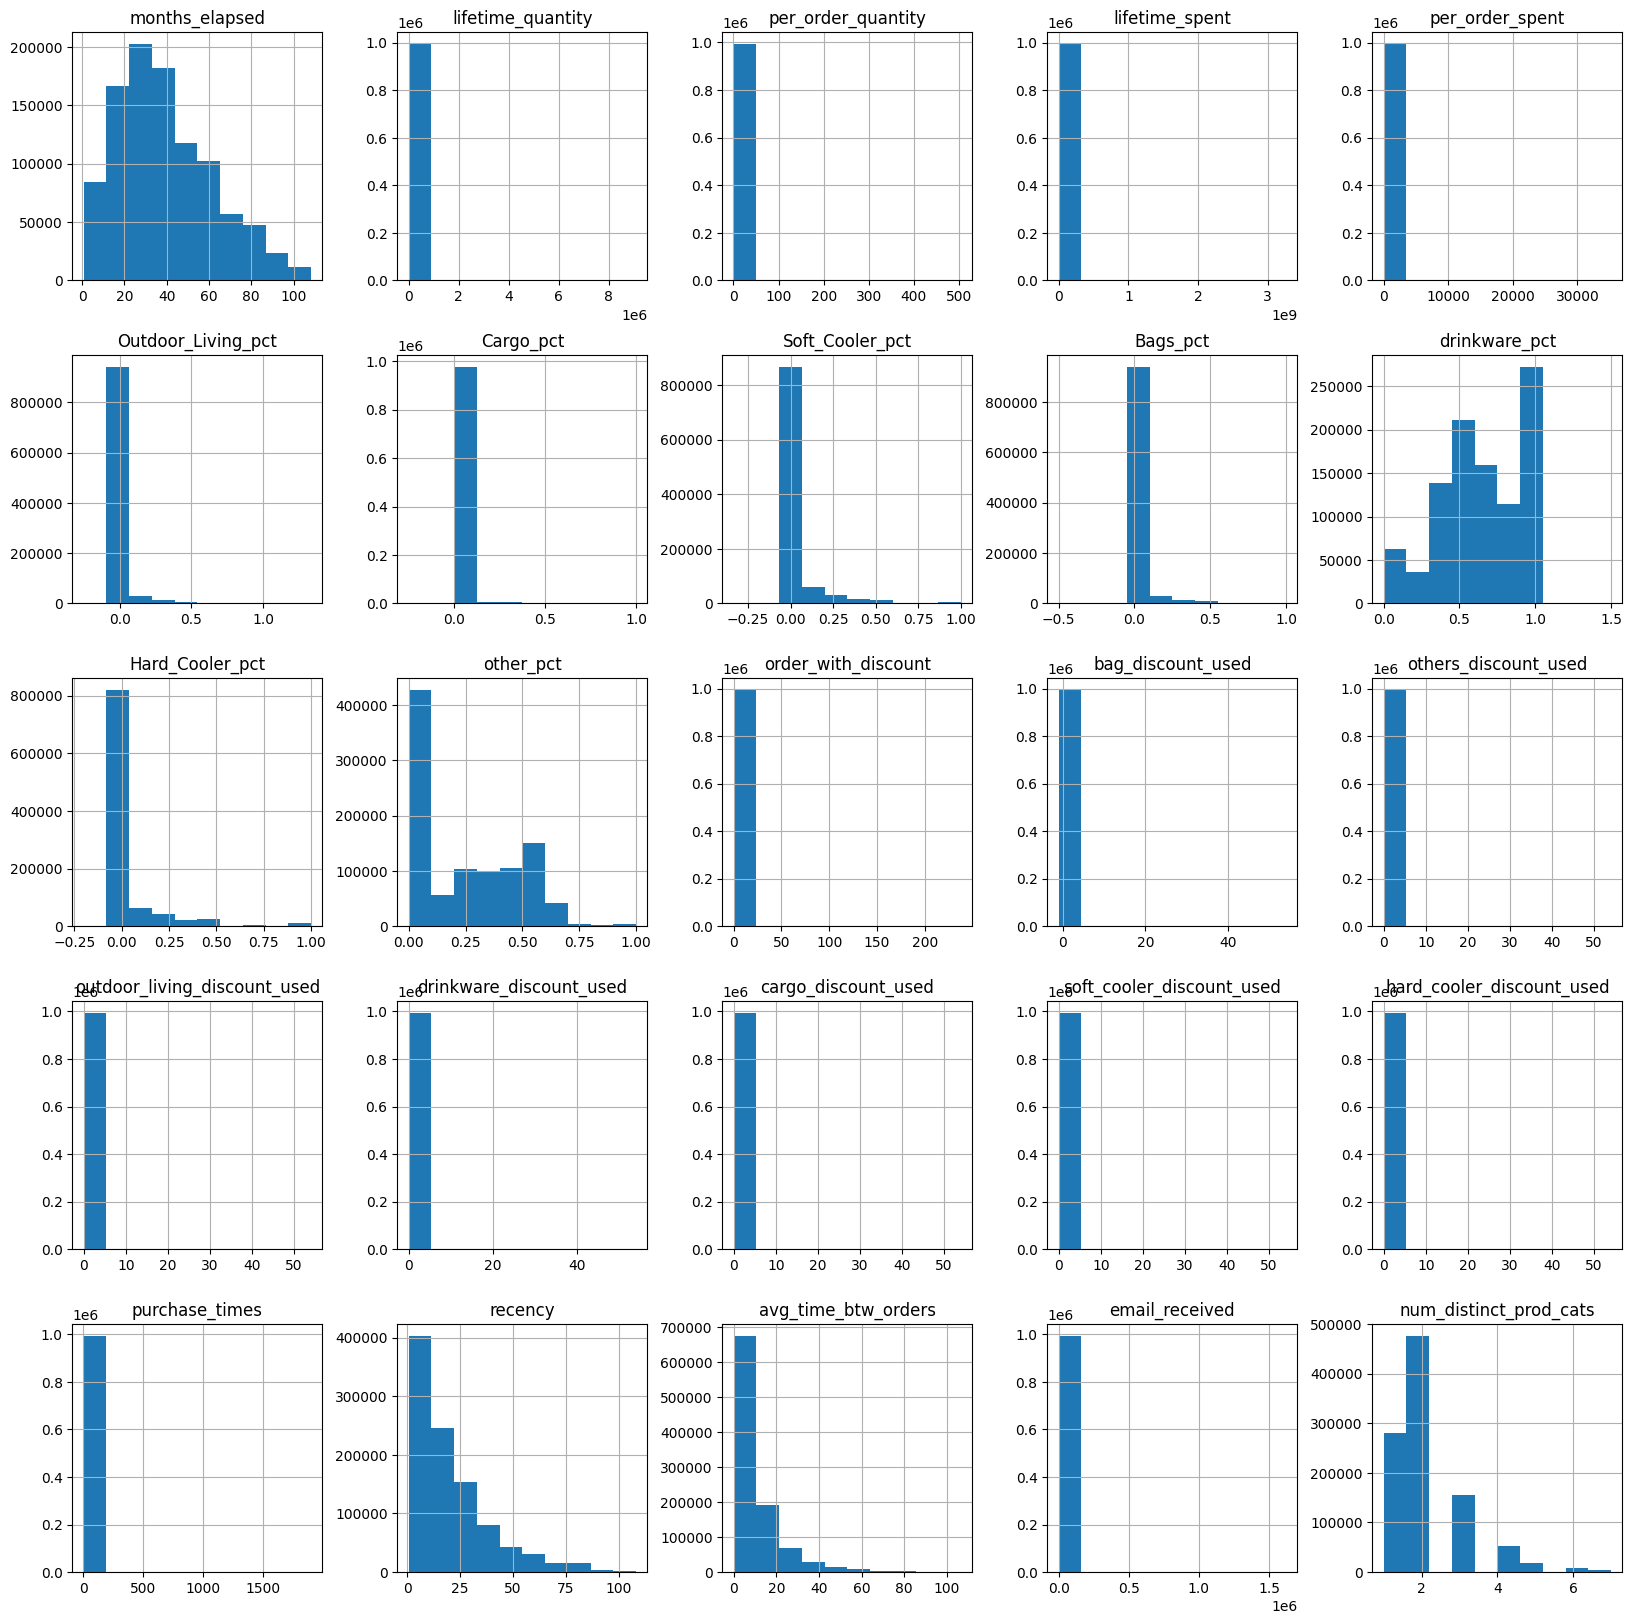

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

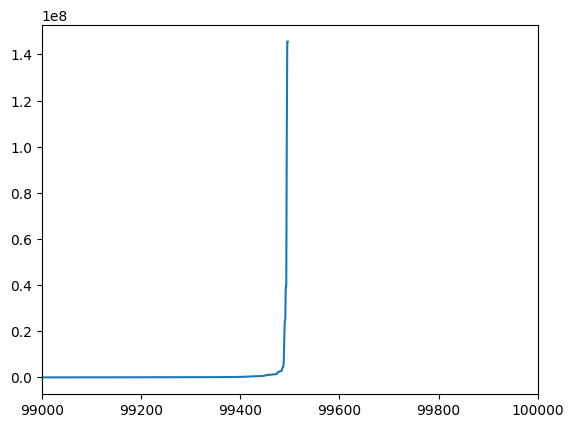

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

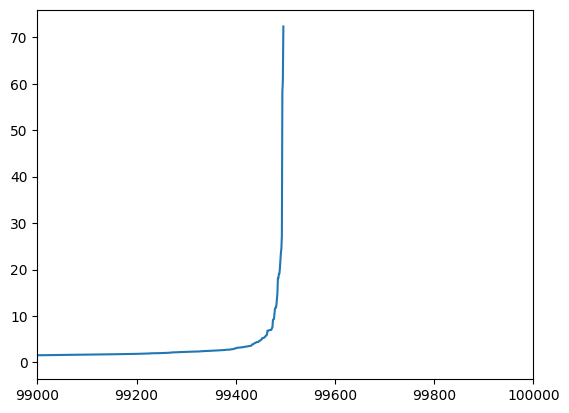

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

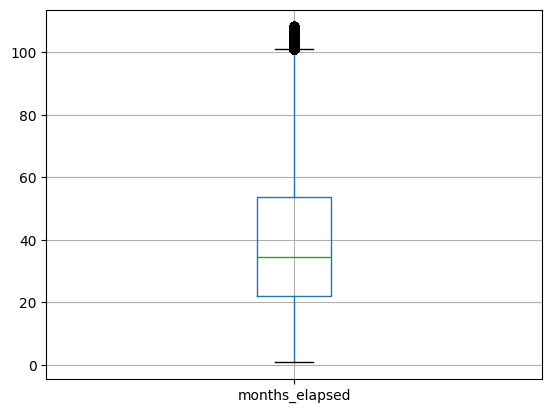

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

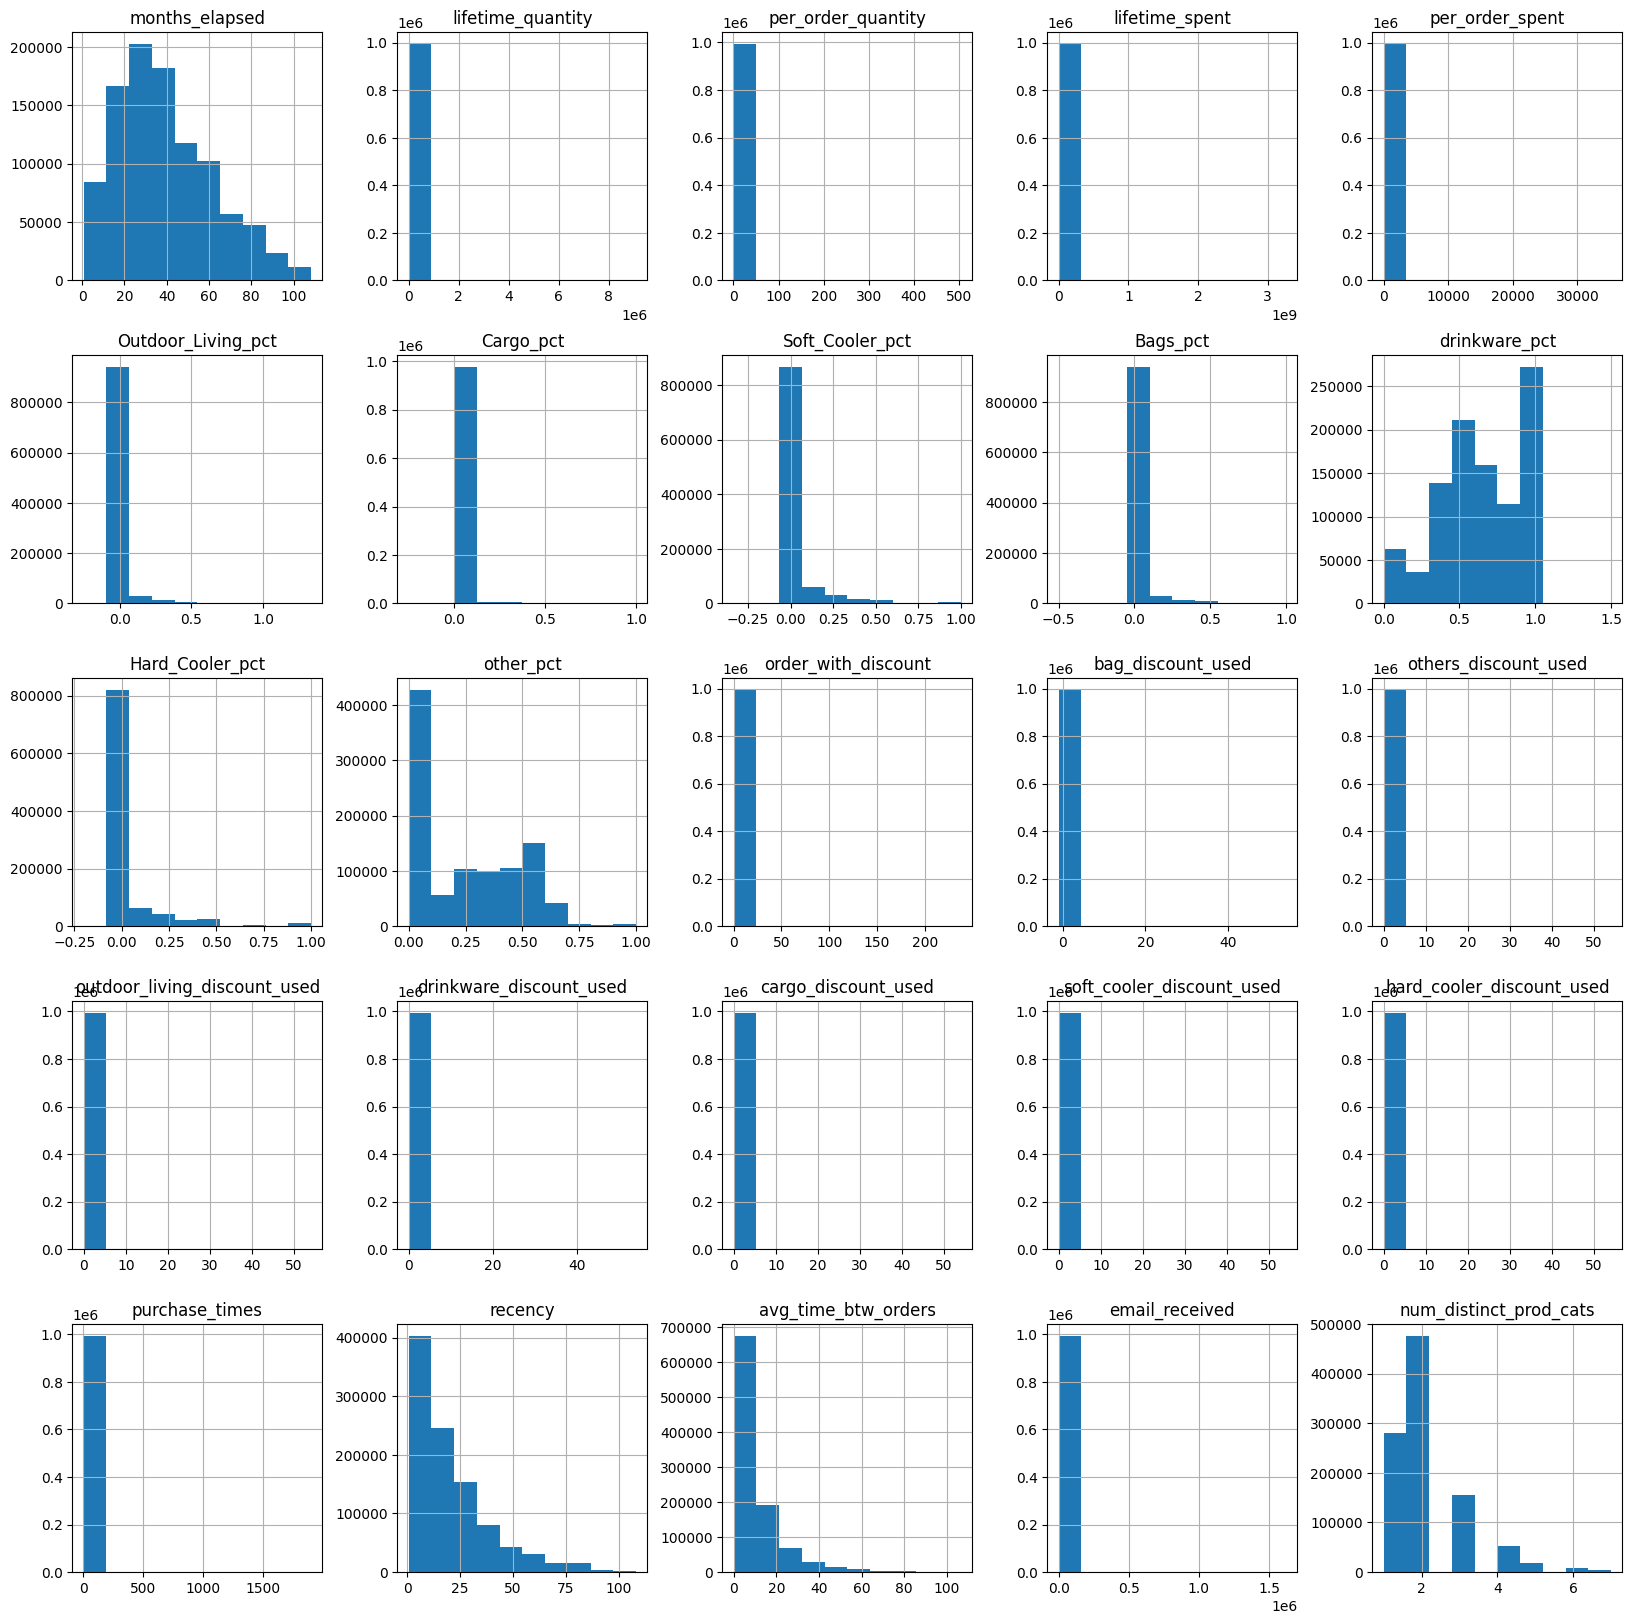

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

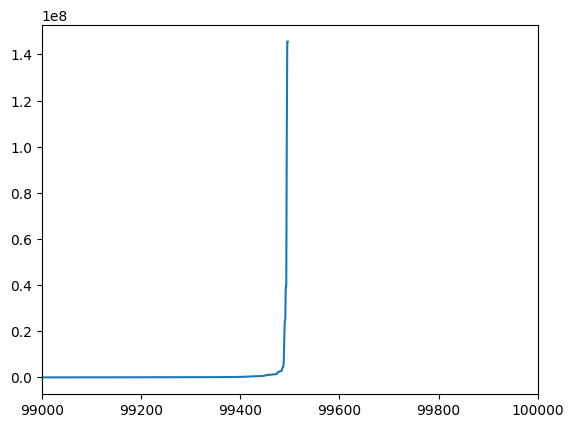

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

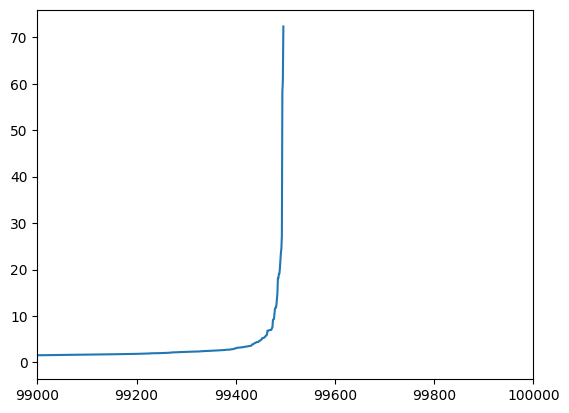

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_merged_2.head()

customer_id  months_elapsed  lifetime_spent  \
0  e75c8f2a-e854-4b5d-b352-01153eabbca1       63.033333          1820.0   
1  eec022da-3335-4923-9f53-b5b2ffb4f951       83.400000        642370.0   
2  d169c27a-4d64-491a-ac64-9704c4076520       64.400000        873022.0   
3  1b5883e9-ce4c-4b5d-a10e-e63b4ddeb733       40.000000       2047134.0   
4  82de77f3-4028-456d-b89b-4866cc365380       70.500000       1250260.0   

   per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0       165.454545                 0.0000    0.00000         0.062500   
1       161.237450                 0.0000    0.00000         0.428571   
2       183.716751                 0.0000    0.00000         0.172414   
3       130.765506                 0.0000    0.00000         0.000000   
4        97.107573                 0.0625    0.03125         0.000000   

   Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  stainless  \
0  0.000000       0.687500         0.000000  ...    0.0      2.0        8.0   
1  0.142857       0.142857         0.000000  ...    0.0      0.0        1.0   
2  0.000000       0.724138         0.103448  ...    8.0      1.0        1.0   
3  0.000000       0.387097         0.032258  ...    NaN      NaN        NaN   
4  0.062500       0.125000         0.156250  ...    NaN      NaN        NaN   

   charcoal  nordic_purple  harvest_red  alpine_yellow  other_color  \
0       1.0            0.0          0.0            0.0          5.0   
1       2.0            0.0          0.0            0.0          4.0   
2       2.0            0.0          0.0            0.0         13.0   
3       NaN            NaN          NaN            NaN          NaN   
4       NaN            NaN          NaN            NaN          NaN   

   lifetime_quantity  per_order_quantity  
0                NaN                 NaN  
1                8.0            2.666667  
2               29.0            2.900000  
3               31.0            6.200000  
4                NaN                 NaN  

[5 rows x 32 columns]

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

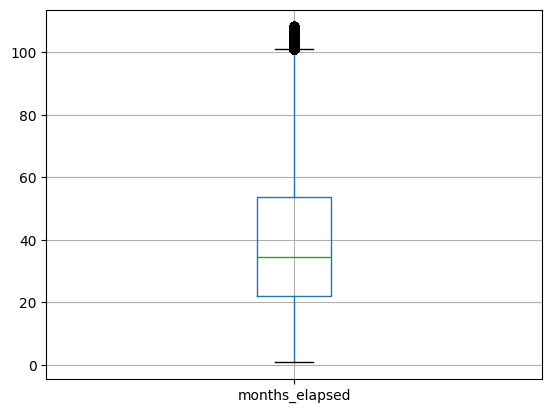

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

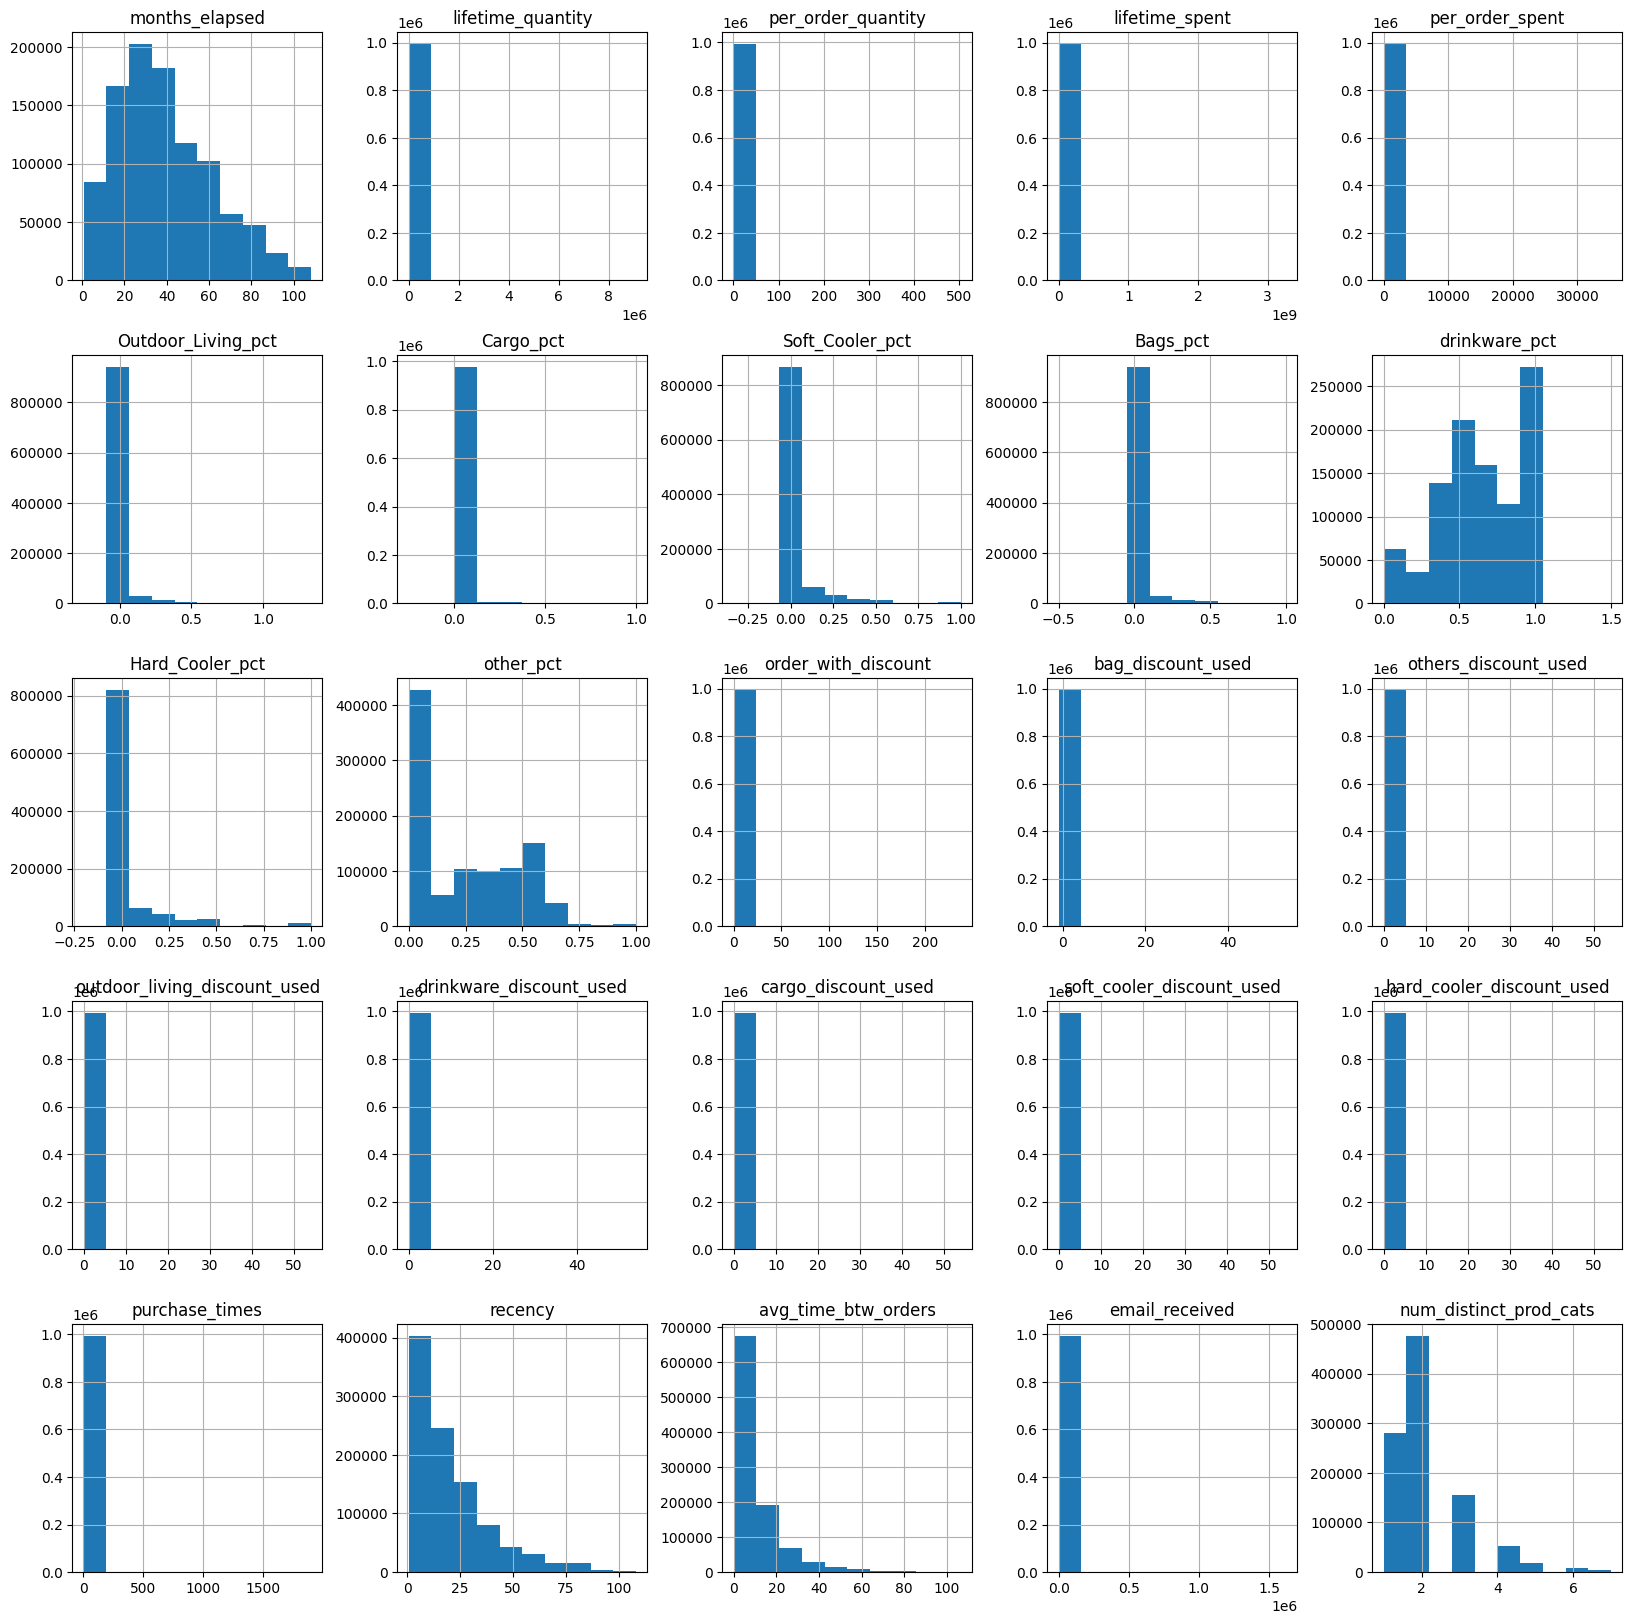

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

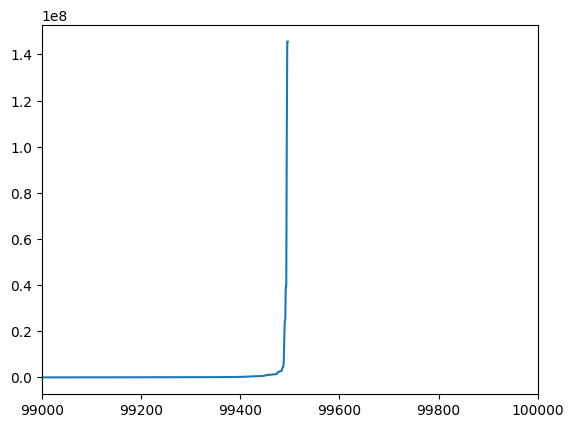

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

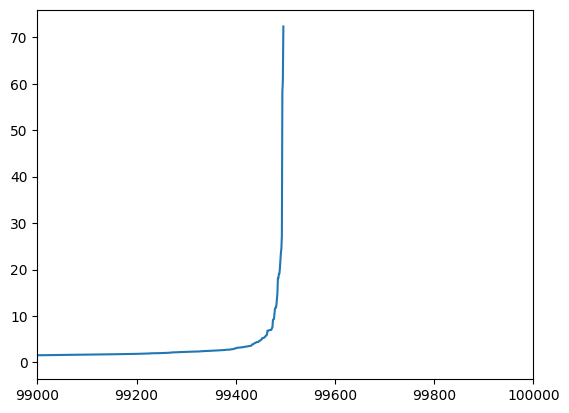

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

In [ ]:
import pandas as pd
import numpy as np
from google.cloud.bigquery import Client, QueryJobConfig
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
with 
#Amount of orders that uses discount
count_discount as 
(with discount_order as(
  select yeti_customer_uuid,orders.order_id, has_discount
from `yeti-dev-edw.aa_anon.aa_order` orders
left join  (
select order_id, 
  case
  when sum(discount)>0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id ) discount on orders.order_id=discount.order_id
)

select c.yeti_customer_uuid,sum(has_discount) as has_discount
from yeti-dev-edw.aa_anon.aa_customer c
left join discount_order d on d.yeti_customer_uuid = c.yeti_customer_uuid

group by c.yeti_customer_uuid

),

dis_prod as (with product_discount as(
select order_id , 
sum(case when product_category="Bags" then quantity end) as bag_discount,
sum(case when product_category="Other" or product_category="not set" then quantity end) as others_discount,
sum(case when product_category="Outdoor Living" then quantity end) as Outdoor_Living_discount,
sum(case when product_category="Drinkware" then quantity end) as Drinkware_discount,
sum(case when product_category="Cargo" then quantity end) as Cargo_discount,
sum(case when product_category="Soft Cooler" then quantity end) as Soft_Cooler_discount,
sum(case when product_category="Hard Cooler" then quantity end) as Hard_Cooler_discount
from yeti-dev-edw.aa_anon.aa_product p
left join yeti-dev-edw.aa_anon.aa_order_item oi
on p.product_id=oi.product_id
where discount>0
group by order_id, product_category)

select customer.yeti_customer_uuid, sum(bag_discount) as bd, sum(others_discount) od, sum(Outdoor_Living_discount) old, sum(Drinkware_discount) dd, sum(Cargo_discount) cd, sum(Soft_Cooler_discount) scd, sum(Hard_Cooler_discount) hcd
from yeti-dev-edw.aa_anon.aa_customer customer
left join yeti-dev-edw.aa_anon.aa_order o on o.yeti_customer_uuid=customer.yeti_customer_uuid
left join product_discount pd on pd.order_id=o.order_id
group by customer.yeti_customer_uuid),

distinct_prod_cat as (
  SELECT 
  order_item.yeti_customer_uuid,
  COUNT(DISTINCT order_item.order_id) as no_of_orders,
  #COUNT(DISTINCT order_item.product_id) as no_of_products, 
  COUNT(DISTINCT product.product_category) as no_of_product_categories
  FROM `yeti-dev-edw.aa_anon.aa_order_item` order_item
  LEFT JOIN `yeti-dev-edw.aa_anon.aa_product` product USING(product_id)
  -- WHERE 
  -- (order_item.source_country = 'US' AND
  -- order_item.site_id = 'Yeti_US')
  GROUP BY order_item.yeti_customer_uuid
  -- HAVING no_of_orders >=2
),

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as Outdoor_Living_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  avg(has_discount) as order_with_discount,

  avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  avg(case when (od) is null then 0 else bd  end ) as others_discount_used,
  avg(case when (old) is null then 0 else bd  end ) as outdoor_living_discount_used,
  avg(case when (dd) is null then 0 else bd  end ) as drinkware_discount_used,
  avg(case when (cd) is null then 0 else bd  end ) as cargo_discount_used,
  avg(case when (scd) is null then 0 else bd  end ) as soft_cooler_discount_used,
  avg(case when (hcd) is null then 0 else bd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  #COUNT(DISTINCT distinct_prod_cat.product_category) as no_of_product_categories
  #AVG(no_of_product_categories) as no_of_product_categories
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats

FROM yeti-dev-edw.aa_anon.aa_customer customer
left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join distinct_prod_cat dpc on  customer.yeti_customer_uuid = dpc.yeti_customer_uuid

left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
  
LIMIT 1000000
"""

job = client.query(query)
df = job.to_dataframe()

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query = """
  SELECT 
  orders.yeti_customer_uuid,
  COUNT(orders.order_id) as num_orders, 
  SUM(orders.order_total) as lifetime_order_value, 
  SUM(order_item.quantity) as lifetime_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order` orders
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order_item` order_item
ON orders.order_id = order_item.order_id
WHERE 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'
GROUP BY yeti_customer_uuid
having 
  count  (distinct orders.order_id) >=2

LIMIT 1000000
"""

job = client.query(query)
data_lietime_order_quantity = job.to_dataframe()

### New Data - Loading DataSet

In [ ]:
# The following two lines are only necessary to run once.
# Comment out otherwise for speed-up.
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

query1 = """
with discount as(
select order_id, 
  case
  when sum(discount)!=0 then 1
  else 0
  end as has_discount
from yeti-dev-edw.aa_anon.aa_order_item
group by order_id )

select o.yeti_customer_uuid as customer_id,sum(has_discount) as has_discount
from discount d
left join `yeti-dev-edw.aa_anon.aa_order` o ON d.order_id=o.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

query2 = """
with join_color as(
with color as (
SELECT  product_id,
(case when color="Black" then 1 else 0 end) as black,
(case when color="Navy"  then 1 else 0 end) as navy,
(case when color="White" then 1 else 0 end) as white,
(case when color="Seafoam" then 1 else 0 end) as seafoam,
(case when color="Stainless" then 1 else 0 end) as stainless,
(case when color="Charcoal" then 1 else 0 end) as charcoal,
(case when color="Nordic Purple" then 1 else 0 end) as nordic_purple,
(case when color="Harvest Red" then 1 else 0 end) as harvest_red,
(case when color="Alpine Yellow" then 1 else 0 end) as alpine_yellow,
(case when color not in("White","Black","Navy","Seafoam","Stainless" ,"Charcoal","Nordic Purple","Harvest Red","Alpine Yellow") then 1 else 0 end) as other_color
from  `yeti-dev-edw.aa_anon.aa_product` p
)

select oi.order_id,oi.order_item_id,
sum(black)*sum(quantity) as black
,sum(navy)*sum(quantity) as navy
,sum(white)*sum(quantity) as white
,sum(seafoam)*sum(quantity) as seafoam
,sum(stainless)*sum(quantity) as stainless
,sum(charcoal)*sum(quantity) as charcoal
,sum(nordic_purple)*sum(quantity) as nordic_purple
,sum(harvest_red)*sum(quantity) as harvest_red
,sum(alpine_yellow)*sum(quantity) as alpine_yellow
,sum(other_color)*sum(quantity) as other_color


from color c
left join  `yeti-dev-edw.aa_anon.aa_order_item` oi on c.product_id=oi.product_id
group by oi.order_id,oi.order_item_id)

select o.yeti_customer_uuid as customer_id, sum (black) as black
,sum(navy) as navy
,sum(white) as white 
,sum(seafoam) as seafoam
,sum(stainless) as stainless
,sum(charcoal) as charcoal
,sum(nordic_purple) as nordic_purple
,sum(harvest_red) as harvest_red
,sum(alpine_yellow) as alpine_yellow
,sum(other_color) as other_color

from join_color jc 
left join  `yeti-dev-edw.aa_anon.aa_order` o on o.order_id=jc.order_id
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""


query3 = """
SELECT o.yeti_customer_uuid as customer_id, SUM(oi.quantity) as lifetime_quantity,    sum(oi.quantity) / count(distinct o.order_id) as per_order_quantity,
FROM `yeti-dev-edw.aa_anon.aa_order_item` oi
LEFT JOIN `yeti-dev-edw.aa_anon.aa_order` o ON oi.order_id=o.order_id
#LEFT JOIN yeti-dev-edw.aa_anon.aa_customer customer ON o.yeti_customer_uuid=customer.yeti_customer_uuid
WHERE o.source_country = 'US' 
  AND o.site_id = 'Yeti_US'
group by o.yeti_customer_uuid
having
  count  (distinct o.order_id) >=2
#limit 1000000
"""

Main_query = """
with 

Product_percentage as (SELECT 
  customer.yeti_customer_uuid, 
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Other'or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Other' or  product.product_category = '(not set)' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Other_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Outdoor Living' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Outdoor_Living_pct,
  CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Drinkware' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Drinkware_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Cargo' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Cargo_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Soft Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Soft_Cooler_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Bags' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Bags_pct,

 CASE 
    WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) = 0 
    THEN 0 
    ELSE 
      CASE 
        WHEN SUM(orderItem.quantity) = 0 
        THEN 0 
        ELSE 
          CASE 
            WHEN SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) < 0 
            THEN -1 * ABS(SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END)) / SUM(orderItem.quantity) 
            ELSE SUM(CASE WHEN product.product_category = 'Hard Cooler' THEN orderItem.quantity ELSE 0 END) / SUM(orderItem.quantity) 
          END 
      END 
  END AS Hard_Cooler_pct,

FROM yeti-dev-edw.aa_anon.aa_customer customer
LEFT JOIN yeti-dev-edw.aa_anon.aa_order orders using(yeti_customer_uuid)
LEFT JOIN yeti-dev-edw.aa_anon.aa_order_item orderItem USING (order_id)
LEFT JOIN yeti-dev-edw.aa_anon.aa_product product USING (product_id)
WHERE product_category IS NOT NULL
GROUP BY yeti_customer_uuid)

SELECT 
  customer.yeti_customer_uuid as customer_id, 
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(min(orders.creation_date)), DAY) / 30 AS months_elapsed,
  #sum(quantity) as lifetime_quantity,
  #sum (case when orderItem.discount>0 then quantity else 0 end) as test,
  #sum(quantity) / count(orders.order_id) as per_order_quantity,
  round(sum(orders.product_total)) as lifetime_spent,
  round(sum(orders.product_total))/ count(orders.order_id) as per_order_spent,

  avg(Outdoor_Living_pct) as outdoor_equipment_pct,
  avg(Cargo_pct) as Cargo_pct,
  avg(Soft_Cooler_pct) as Soft_Cooler_pct,
  avg(Bags_pct) as Bags_pct,
  avg(Drinkware_pct) as drinkware_pct,
  avg(Hard_Cooler_pct) as Hard_Cooler_pct,
  avg(Other_pct) as other_pct,
  #avg(has_discount) as order_with_discount,

  #avg(case when (bd) is null then 0 else bd  end ) as bag_discount_used,
  #avg(case when (od) is null then 0 else od  end ) as others_discount_used,
  #avg(case when (old) is null then 0 else old  end ) as outdoor_living_discount_used,
  #avg(case when (dd) is null then 0 else dd  end ) as drinkware_discount_used,
  #avg(case when (cd) is null then 0 else cd  end ) as cargo_discount_used,
  #avg(case when (scd) is null then 0 else scd  end ) as soft_cooler_discount_used,
  #avg(case when (hcd) is null then 0 else hcd  end ) as hard_cooler_discount_used,

  count(distinct orders.order_id) as purchase_times,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(orders.creation_date)), DAY) / 30 AS recency,
  subquery.avg_time_btw_orders as avg_time_btw_orders,
  COUNT(email_id) as email_received,
  COUNT(CASE WHEN last_open_date IS NOT NULL THEN 1 END) / NULLIF(COUNT(email_id),0) AS email_open_rate,
  CASE WHEN COUNT(email_id) = 0 THEN NULL ELSE MAX(CASE WHEN unsub_count > 0 THEN 1 ELSE 0 END) END AS unsubscribed,
  TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_open_date)), DAY) / 30 AS months_since_last_email_open,
  -- TIMESTAMP_DIFF(CURRENT_TIMESTAMP(), TIMESTAMP(max(email.last_unsub_date)), DAY) / 30 AS months_since_last_ubsubscribe,
  -- avg(Outdoor_Living_pct), avg(Cargo_pct), avg(Soft_Cooler_pct),avg(Bags_pct),avg(Drinkware_pct),avg(Hard_Cooler_pct),avg(Other_pct)
  CASE 
    WHEN avg(Outdoor_Living_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Cargo_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Soft_Cooler_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Bags_pct) <> 0 THEN 1 ELSE 0 
  END + 
  CASE 
    WHEN avg(Drinkware_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Hard_Cooler_pct) <> 0 THEN 1 ELSE 0
  END + 
  CASE 
    WHEN avg(Other_pct) <> 0 THEN 1 ELSE 0
  END as num_distinct_prod_cats
FROM yeti-dev-edw.aa_anon.aa_customer customer
#left join count_discount cd2 on cd2.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order orders on orders.yeti_customer_uuid= customer.yeti_customer_uuid
#left join dis_prod dp on dp.yeti_customer_uuid= customer.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_order_item orderItem using(order_id)
left join Product_percentage pp on customer.yeti_customer_uuid=pp.yeti_customer_uuid
left join  yeti-dev-edw.aa_anon.aa_email email  on customer.yeti_customer_uuid=email.yeti_customer_uuid
left join (
  SELECT yeti_customer_uuid, 
    count(order_id) as no_of_orders,  
    (AVG(TIMESTAMP_DIFF(TIMESTAMP(creation_date),TIMESTAMP(lag_order_date),DAY)))/30 as avg_time_btw_orders 
  FROM ( 
    SELECT yeti_customer_uuid, order_id,creation_date, 
      lag(creation_date) OVER (PARTITION BY yeti_customer_uuid ORDER BY creation_date) as lag_order_date  
    FROM `yeti-dev-edw.aa_anon.aa_order`  
  )
  GROUP BY yeti_customer_uuid
  HAVING count(order_id) >= 2
) subquery ON subquery.yeti_customer_uuid = customer.yeti_customer_uuid

where 
  orders.source_country = 'US' 
  AND orders.site_id = 'Yeti_US'

group by 
  customer.yeti_customer_uuid, 
  subquery.avg_time_btw_orders

having 
  count  (distinct orders.order_id) >=2
#limit 1000000
"""

job1 = client.query(query1)
job2 = client.query(query2)
job3 = client.query(query3)
job4 = client.query(Main_query)

df_has_discount = job1.to_dataframe()
df_color_count = job2.to_dataframe()
df_lifetime_quantity = job3.to_dataframe()
df= job4.to_dataframe()


In [ ]:
main_lifetime_qt_merged = pd.merge(df,df_lifetime_quantity,on = 'customer_id', how = 'left')

In [ ]:
main_lifetime_qt_discounts_merged = pd.merge(main_lifetime_qt_merged,df_has_discount,on='customer_id',how='left')

In [ ]:
df_all_merged = pd.merge(main_lifetime_qt_discounts_merged,df_color_count, on = 'customer_id', how = 'left')

In [ ]:
df_all_merged.to_csv('data_all_merged_03_08_23_vfinal.csv')

In [ ]:
df_all_merged

customer_id  months_elapsed  lifetime_spent  \
0        b32e89d5-a934-4d77-8b86-e01bf270fce6       83.700000       1771002.0   
1        20a5cbb9-216a-4bfb-84f8-34316cc990f0       64.566667        766093.0   
2        564fd988-bc35-475f-b7f6-da04ae474422       56.066667        910602.0   
3        e6867db2-26c5-4841-8822-863bce76f5b0       69.266667       1137507.0   
4        36a6c5a8-955a-457e-8509-83b7e0644856       23.666667       2138149.0   
...                                       ...             ...             ...   
2131515  c6882f0e-203b-41f7-bc5f-1f24713a3179       47.566667          3749.0   
2131516  1cb47d1e-ead0-4432-8d40-53ce0d3df887       86.700000        357405.0   
2131517  3973bf5a-f1db-4a38-8ffb-bfd8a46a5027       58.966667        667411.0   
2131518  902a88ec-2eee-444f-a524-c7f0e5f5c3bc       35.066667        243385.0   
2131519  5c0f3bd7-0c43-4fa6-84c0-60d200775121       59.100000         31723.0   

         per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
0             124.806342               0.000000        0.0         0.000000   
1             194.637449               0.000000        0.0         0.055556   
2              91.288421               0.047619        0.0         0.000000   
3              84.787343               0.125000        0.0         0.000000   
4             386.995294               0.000000        0.0         0.176471   
...                  ...                    ...        ...              ...   
2131515       178.523810               0.000000        0.0         0.000000   
2131516       120.826572               0.000000        0.0         0.000000   
2131517        64.728057               0.000000        0.0         0.000000   
2131518        69.261525               0.000000        0.0         0.000000   
2131519        55.266551               0.000000        0.0         0.000000   

         Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  black  navy  white  \
0        0.000000       0.974359         0.025641  ...    5.0   4.0    5.0   
1        0.000000       0.944444         0.000000  ...    3.0   2.0    0.0   
2        0.000000       0.619048         0.047619  ...    0.0   1.0    0.0   
3        0.000000       0.437500         0.000000  ...    0.0   8.0    0.0   
4        0.058824       0.588235         0.000000  ...    4.0   1.0    0.0   
...           ...            ...              ...  ...    ...   ...    ...   
2131515  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131516  0.000000       0.857143         0.142857  ...    1.0   1.0    0.0   
2131517  0.000000       0.857143         0.000000  ...    3.0   3.0    0.0   
2131518  0.000000       0.857143         0.000000  ...    0.0   1.0    1.0   
2131519  0.000000       0.857143         0.000000  ...    1.0   0.0    0.0   

         seafoam  stainless  charcoal  nordic_purple  harvest_red  \
0            1.0        5.0       0.0            0.0          0.0   
1            0.0        0.0       1.0            0.0          0.0   
2            2.0        0.0       0.0            0.0          0.0   
3            4.0        0.0       0.0            0.0          0.0   
4            1.0        0.0       1.0            1.0          0.0   
...          ...        ...       ...            ...          ...   
2131515      1.0        0.0       0.0            0.0          0.0   
2131516      0.0        2.0       0.0            1.0          0.0   
2131517      0.0        0.0       0.0            0.0          0.0   
2131518      0.0        0.0       0.0            0.0          0.0   
2131519      0.0        1.0       0.0            0.0          0.0   

         alpine_yellow  other_color  
0                  0.0         19.0  
1                  0.0         12.0  
2                  0.0         18.0  
3                  0.0         20.0  
4                  0.0          9.0  
...                ...          ...  
2131515            0.0          4.0  
2131516            0.0          2.0  
2131

In [ ]:
df_merged_2.isna().sum()

customer_id                          0
months_elapsed                       0
lifetime_spent                       0
per_order_spent                      0
outdoor_equipment_pct             1217
Cargo_pct                         1217
Soft_Cooler_pct                   1217
Bags_pct                          1217
drinkware_pct                     1217
Hard_Cooler_pct                   1217
other_pct                         1217
purchase_times                       0
recency                              0
avg_time_btw_orders                  0
email_received                       0
email_open_rate                 180138
unsubscribed                    180138
months_since_last_email_open    256241
num_distinct_prod_cats               0
has_discount                    531100
black                           530535
navy                            530535
white                           530535
seafoam                         530535
stainless                       530535
charcoal                 

### Saving the CSV

In [ ]:
df_merged_2.to_csv('df_merged_03_08_23.csv')

In [ ]:
df_merged_2.dropna()

customer_id  months_elapsed  lifetime_spent  \
23      72bbc1d8-0143-4aff-bedd-d158fabac5d8        9.133333        453929.0   
31      1bb8fad3-3b1f-439f-baab-e8ea18eb8e49       43.100000        235665.0   
40      a6d5d106-1042-4d7c-a51b-515eb7e525bd       87.500000       2905721.0   
66      64776869-9d89-4b31-85db-110925ea1b48       65.600000       3009188.0   
73      91dae97e-894d-4269-b7a7-fdbbb422f5fb       48.800000       4231567.0   
...                                      ...             ...             ...   
999857  ea636051-9a1e-4f21-b03b-1a85236f5bfb       69.900000        336403.0   
999890  57e710ab-0546-489f-9164-f3e6ec1a8c76       60.266667        130190.0   
999960  28225b48-1028-429f-b0fd-2653fc1ed82a       34.400000       1456932.0   
999963  a5782a40-47e0-431d-b255-a33fe1c070cf       23.900000         49392.0   
999970  d5dc53f6-7dad-470a-a999-6f38610572b5       30.900000        277166.0   

        per_order_spent  outdoor_equipment_pct  Cargo_pct  Soft_Cooler_pct  \
23           213.312500               0.000000   0.000000         0.125000   
31           121.979814               0.142857   0.000000         0.000000   
40            82.492647               0.070423   0.028169         0.056338   
66           295.598035               0.000000   0.000000         0.000000   
73           224.856103               0.000000   0.000000         0.000000   
...                 ...                    ...        ...              ...   
999857        50.693641               0.000000   0.000000         0.000000   
999890        62.833012               0.142857   0.000000         0.000000   
999960       136.034734               0.000000   0.000000         0.000000   
999963        44.983607               0.000000   0.000000         0.142857   
999970       164.979762               0.000000   0.000000         0.142857   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  white  seafoam  \
23      0.062500       0.312500         0.000000  ...    0.0      0.0   
31      0.000000       0.357143         0.142857  ...    1.0      2.0   
40      0.028169       0.408451         0.140845  ...    3.0      1.0   
66      0.000000       0.550000         0.000000  ...    0.0      0.0   
73      0.000000       0.465116         0.000000  ...    1.0      4.0   
...          ...            ...              ...  ...    ...      ...   
999857  0.000000       0.857143         0.000000  ...    0.0      3.0   
999890  0.000000       0.857143         0.000000  ...    0.0      1.0   
999960  0.000000       0.857143         0.000000  ...    3.0      1.0   
999963  0.000000       0.857143         0.000000  ...    0.0      1.0   
999970  0.000000       0.857143         0.000000  ...    0.0      1.0   

        stainless  charcoal  nordic_purple  harvest_red  alpine_yellow  \
23            0.0       0.0            0.0          0.0            3.0   
31            0.0       0.0            0.0          0.0            0.0   
40            4.0       3.0            0.0          0.0            0.0   
66            0.0       0.0            0.0          0.0            0.0   
73            0.0       0.0            0.0          0.0            0.0   
...           ...       ...            ...          ...            ...   
999857        0.0       1.0            0.0          0.0            0.0   
999890        0.0       0.0            0.0          0.0            0.0   
999960        0.0       0.0            0.0          0.0            2.0   
999963        0.0       0.0            0.0          0.0            0.0   
999970        0.0       0.0            0.0          0.0            0.0   

        other_color  lifetime_quantity  per_order_quantity  
23             12.0               16.0            4.000000  
31             10.0               14.0            2.333333  
40             52.0               71.0            1.690476  
66             20.0               20.0           10.000000  
73             33.0               43.0            8.600000  
...

##### email open_rate, months since lasts  email open and unsubscribed have a lot of nulls. We need to drop these columns

In [ ]:
data_lietime_order_quantity

yeti_customer_uuid  num_orders  \
0       890e0b93-c433-4839-9c2f-01929ec8736a          83   
1       5f9ec3e4-6feb-487e-a65c-2b7155ed345a          18   
2       294c044c-171d-43d6-8533-4c9726e2be33          14   
3       f3aae112-3415-4ae7-bc5c-2c309702dd8f          67   
4       72af527c-d4fa-4f67-9695-79018aac94ac          34   
...                                      ...         ...   
999995  f40376f8-42cc-4ffc-9f25-2c2d9eefbbaa          25   
999996  573ec4ce-c232-45e3-aef3-ab8beb3cd379          26   
999997  a73210e4-b475-4f46-a00e-e481997d8291           6   
999998  b627f625-4f46-4890-8957-afcf882f7b58          23   
999999  3cc868a5-b63a-459a-9e4e-2e32dfb6466b          25   

        lifetime_order_value  lifetime_order_quantity  
0                   28220.33                    288.0  
1                    2764.81                     32.0  
2                    1722.94                     32.0  
3                   15176.30                     69.0  
4                    7189.80                     34.0  
...                      ...                      ...  
999995               4866.12                     26.0  
999996               1557.70                     26.0  
999997               1239.51                     26.0  
999998               1974.80                     26.0  
999999               3063.27                     26.0  

[1000000 rows x 4 columns]

In [ ]:
lifetime_order_quantity_testdf = pd.merge(df,data_lietime_order_quantity, how ='inner',left_on = 'customer_id',right_on='yeti_customer_uuid')[['customer_id','yeti_customer_uuid','lifetime_quantity','lifetime_order_quantity']]
lifetime_order_quantity_testdf

customer_id  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7   
1       3377b0e8-df56-46db-aade-a312d779dbf1   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824   
3       79f33368-d8cf-400b-957a-fa4648fafdc1   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc   
...                                      ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6   

                          yeti_customer_uuid  lifetime_quantity  \
0       fa87d5e1-cfd3-4f06-9dc9-85c04b321af7                2.0   
1       3377b0e8-df56-46db-aade-a312d779dbf1                3.0   
2       9a954e0f-c9e3-4bdf-80f3-fbbc22404824             1720.0   
3       79f33368-d8cf-400b-957a-fa4648fafdc1              495.0   
4       73476cc4-6335-4fc0-869c-fa9a40007cdc                2.0   
...                                      ...                ...   
469242  5cb6ce1f-157d-41c5-a222-b6e46133311b                3.0   
469243  2f9c521b-c16e-4ef7-8e7f-bbfc2a668c48               88.0   
469244  f67e7218-19df-4acd-8d24-f9062cd65e79             3078.0   
469245  5957afa4-f04f-446f-95cb-ce0be414aa99               75.0   
469246  dc6fc266-3315-4ab3-95e5-90128052e0c6                2.0   

        lifetime_order_quantity  
0                           2.0  
1                           3.0  
2                           4.0  
3                          11.0  
4                           2.0  
...                         ...  
469242                      3.0  
469243                     11.0  
469244                      6.0  
469245                     75.0  
469246                      2.0  

[469247 rows x 4 columns]

In [ ]:
df.columns

Index(['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received', 'email_open_rate',
       'unsubscribed', 'months_since_last_email_open',
       'months_since_last_ubsubscribe', 'num_distinct_prod_cats'],
      dtype='object')

In [ ]:
df = df[['customer_id', 'months_elapsed', 'lifetime_quantity',
       'per_order_quantity', 'lifetime_spent', 'per_order_spent',
       'Outdoor_Living_pct', 'Cargo_pct', 'Soft_Cooler_pct', 'Bags_pct',
       'drinkware_pct', 'Hard_Cooler_pct', 'other_pct', 'order_with_discount',
       'bag_discount_used', 'others_discount_used',
       'outdoor_living_discount_used', 'drinkware_discount_used',
       'cargo_discount_used', 'soft_cooler_discount_used',
       'hard_cooler_discount_used', 'purchase_times', 'recency',
       'avg_time_btw_orders', 'email_received','num_distinct_prod_cats']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   customer_id                   1000000 non-null  object 
 1   months_elapsed                1000000 non-null  float64
 2   lifetime_quantity             1000000 non-null  float64
 3   per_order_quantity            1000000 non-null  float64
 4   lifetime_spent                1000000 non-null  float64
 5   per_order_spent               1000000 non-null  float64
 6   Outdoor_Living_pct            998773 non-null   float64
 7   Cargo_pct                     998773 non-null   float64
 8   Soft_Cooler_pct               998773 non-null   float64
 9   Bags_pct                      998773 non-null   float64
 10  drinkware_pct                 998773 non-null   float64
 11  Hard_Cooler_pct               998773 non-null   float64
 12  other_pct                    

In [ ]:
df.dropna(inplace = True) #Drop the rows where at least one element is missing.

### Taking a random sample for EDA - random sample of 10% of the data

In [ ]:
df_sample = df.sample(frac=0.1, replace=False, random_state=1)

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99497 entries, 201121 to 719865
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   99497 non-null  object 
 1   months_elapsed                99497 non-null  float64
 2   lifetime_quantity             99497 non-null  float64
 3   per_order_quantity            99497 non-null  float64
 4   lifetime_spent                99497 non-null  float64
 5   per_order_spent               99497 non-null  float64
 6   Outdoor_Living_pct            99497 non-null  float64
 7   Cargo_pct                     99497 non-null  float64
 8   Soft_Cooler_pct               99497 non-null  float64
 9   Bags_pct                      99497 non-null  float64
 10  drinkware_pct                 99497 non-null  float64
 11  Hard_Cooler_pct               99497 non-null  float64
 12  other_pct                     99497 non-null  float64


<AxesSubplot:>

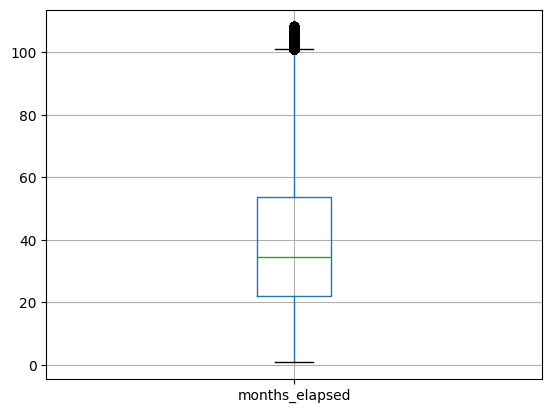

In [ ]:
df[['months_elapsed']].boxplot()

array([[<AxesSubplot:title={'center':'months_elapsed'}>,
        <AxesSubplot:title={'center':'lifetime_quantity'}>,
        <AxesSubplot:title={'center':'per_order_quantity'}>,
        <AxesSubplot:title={'center':'lifetime_spent'}>,
        <AxesSubplot:title={'center':'per_order_spent'}>],
       [<AxesSubplot:title={'center':'Outdoor_Living_pct'}>,
        <AxesSubplot:title={'center':'Cargo_pct'}>,
        <AxesSubplot:title={'center':'Soft_Cooler_pct'}>,
        <AxesSubplot:title={'center':'Bags_pct'}>,
        <AxesSubplot:title={'center':'drinkware_pct'}>],
       [<AxesSubplot:title={'center':'Hard_Cooler_pct'}>,
        <AxesSubplot:title={'center':'other_pct'}>,
        <AxesSubplot:title={'center':'order_with_discount'}>,
        <AxesSubplot:title={'center':'bag_discount_used'}>,
        <AxesSubplot:title={'center':'others_discount_used'}>],
       [<AxesSubplot:title={'center':'outdoor_living_discount_used'}>,
        <AxesSubplot:title={'center':'drinkware_discount_use

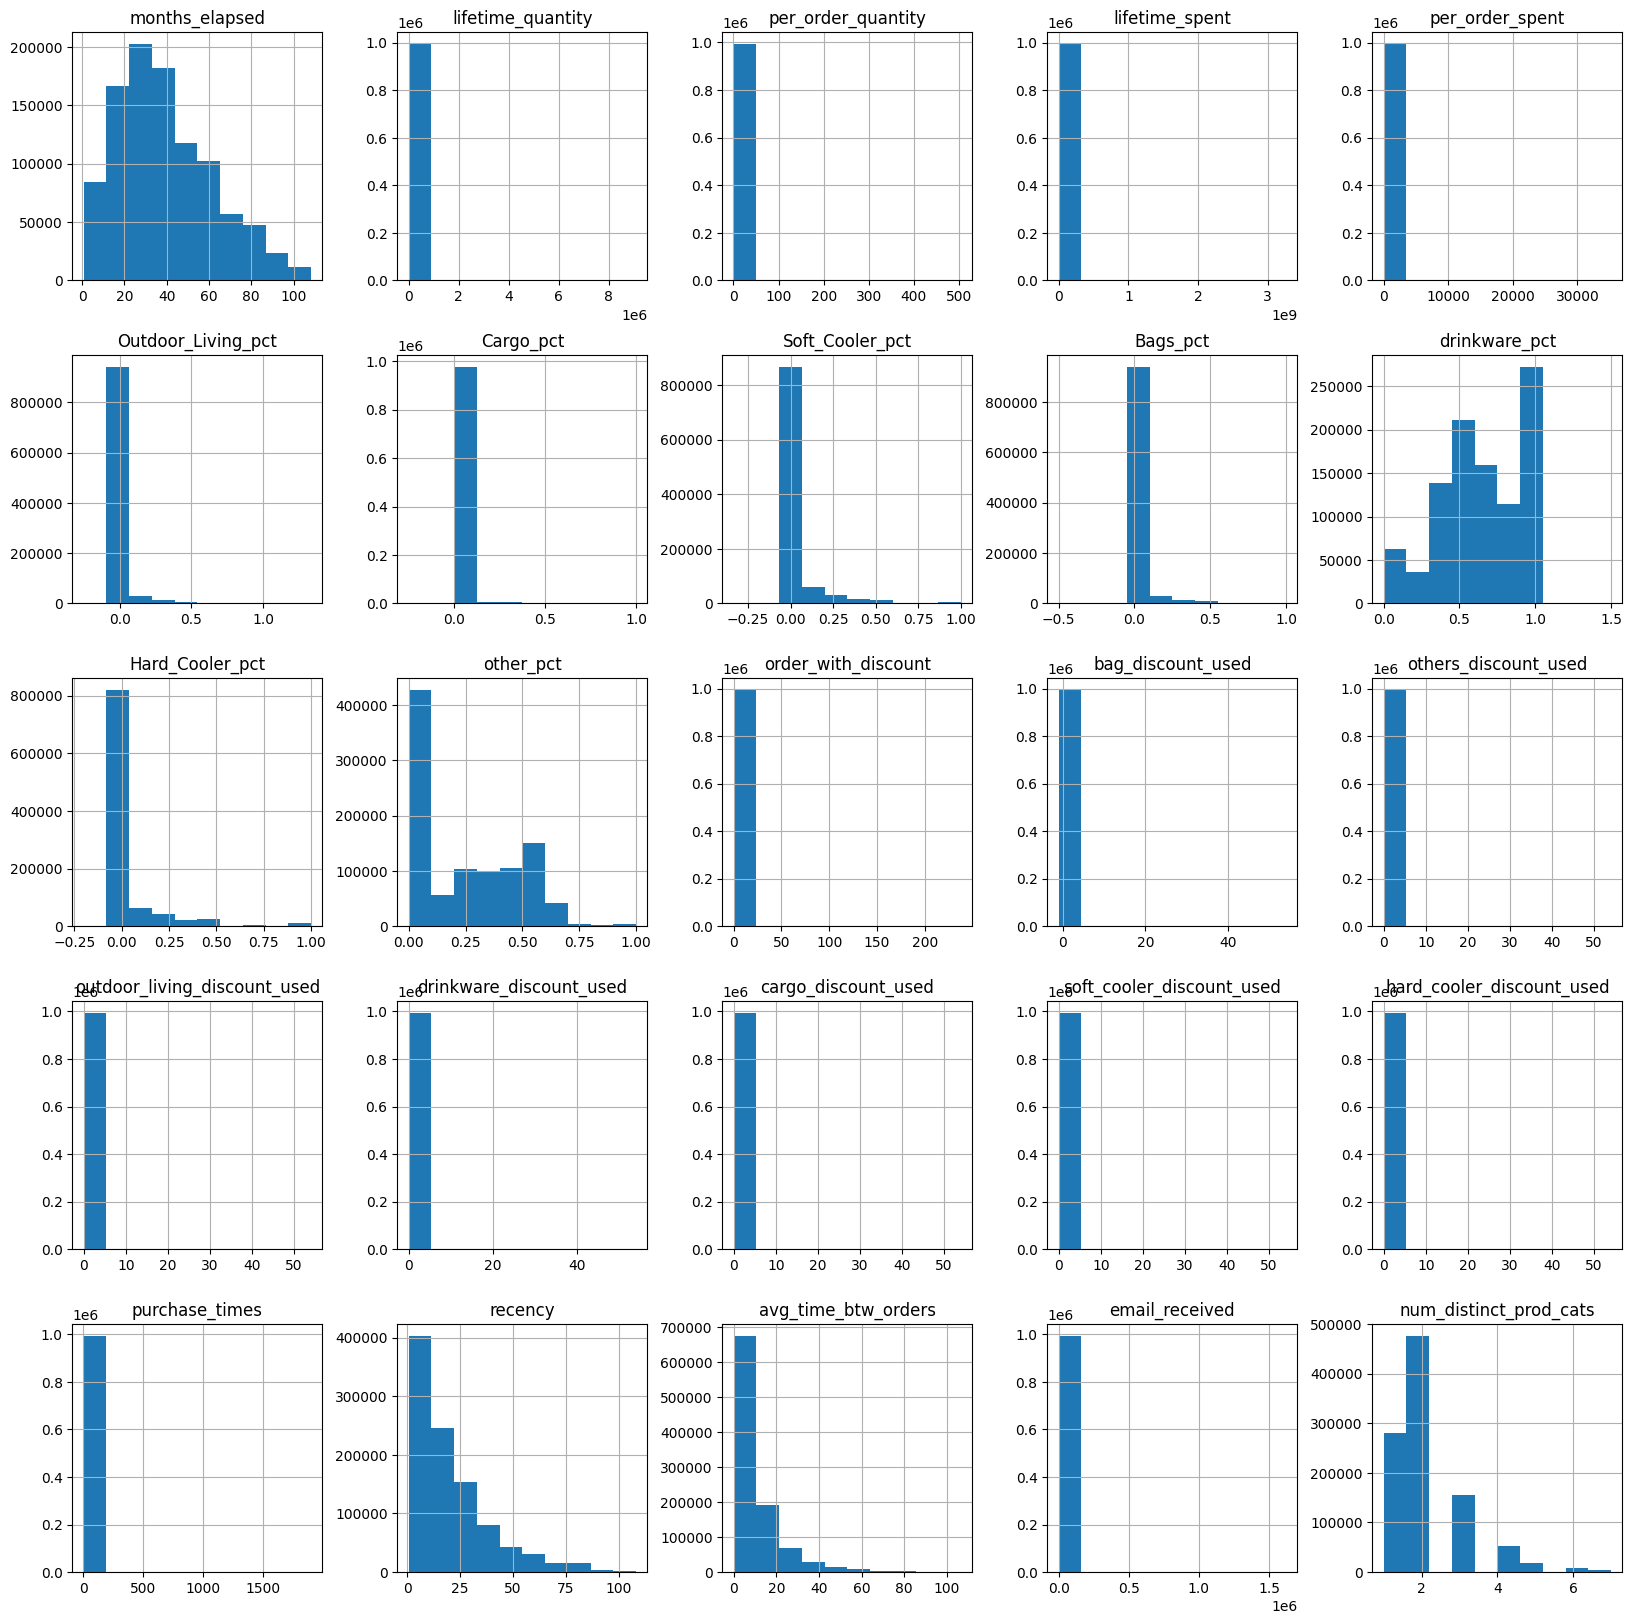

In [ ]:
df.hist(figsize = (20,20))

#### Insights:- 
- Majority of customers buy Drinkware 
- Majority of Customers buy 

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
DBS_clustering = DBSCAN(eps = 0.01, min_samples = 50)

In [ ]:
df_sample.iloc[:,2:]

lifetime_quantity  per_order_quantity  lifetime_spent  \
201121                8.0            1.600000           892.0   
384190                3.0            1.000000           950.0   
873486             1244.0            1.333333        139944.0   
957247              580.0            1.000000        173994.0   
540366              266.0            1.000000          8014.0   
...                   ...                 ...             ...   
95598               423.0            1.000000         27072.0   
601346             1956.0            1.000000        100235.0   
745146              576.0            1.000000         70131.0   
549331                7.0            1.750000           277.0   
719865               24.0            1.000000          1506.0   

        per_order_spent  Outdoor_Living_pct  Cargo_pct  Soft_Cooler_pct  \
201121       178.400000            0.000000        0.0         0.125000   
384190       316.666667            0.000000        0.0         0.333333   
873486       149.993569            0.000000        0.0         0.250000   
957247       299.989655            0.000000        0.0         1.000000   
540366        30.127820            0.000000        0.0         0.000000   
...                 ...                 ...        ...              ...   
95598         64.000000            0.000000        0.0         0.000000   
601346        51.244888            0.000000        0.0         0.000000   
745146       121.755208            0.111111        0.0         0.000000   
549331        69.250000            0.000000        0.0         0.000000   
719865        62.750000            0.000000        0.0         0.000000   

        Bags_pct  drinkware_pct  Hard_Cooler_pct  ...  \
201121  0.000000       0.125000         0.000000  ...   
384190  0.333333       0.000000         0.333333  ...   
873486  0.000000       0.500000         0.250000  ...   
957247  0.000000       0.000000         0.000000  ...   
540366  0.000000       0.571429         0.000000  ...   
...          ...            ...              ...  ...   
95598   0.000000       1.000000         0.000000  ...   
601346  0.000000       1.000000         0.000000  ...   
745146  0.000000       0.444444         0.000000  ...   
549331  0.000000       0.857143         0.000000  ...   
719865  0.000000       0.583333         0.083333  ...   

        outdoor_living_discount_used  drinkware_discount_used  \
201121                           0.0                      0.0   
384190                           0.0                      0.0   
873486                           0.0                      0.0   
957247                           0.0                      0.0   
540366                           0.0                      0.0   
...                              ...                      ...   
95598                            0.0                      0.0   
601346                           0.0                      0.0   
745146                           0.0                      0.0   
549331                           0.0                      0.0   
719865                           0.0                      0.0   

        cargo_discount_used  soft_cooler_discount_used  \
201121                  0.0                        0.0   
384190                  0.0                        0.0   
873486                  0.0                        0.0   
957247                  0.0                        0.0   
540366                  0.0                        0.0   
...                     ...                        ...   
95598                   0.0                        0.0   
601346                  0.0                        0.0   
745146                  0.0                        0.0   
549331                  0.0                        0.0   
719865                  0.0                        0.0   

        hard_cooler_discount_used  purchase_times    recency  \
201121                        0.0               2  13.133333   
384190                        0.0  

In [ ]:
DBS_clustering.fit(df_sample.iloc[:,2:])

DBSCAN(eps=0.01, min_samples=50)

In [ ]:
clusters = DBS_clustering.labels_

In [ ]:
pd.DataFrame(clusters).value_counts()

-1    99497
dtype: int64

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(df_sample.iloc[:,2:])

In [ ]:
distances, indices = nbrs.kneighbors(df_sample.iloc[:,2:])

In [ ]:
distances= np.sort(distances,axis = 0)

(99000.0, 100000.0)

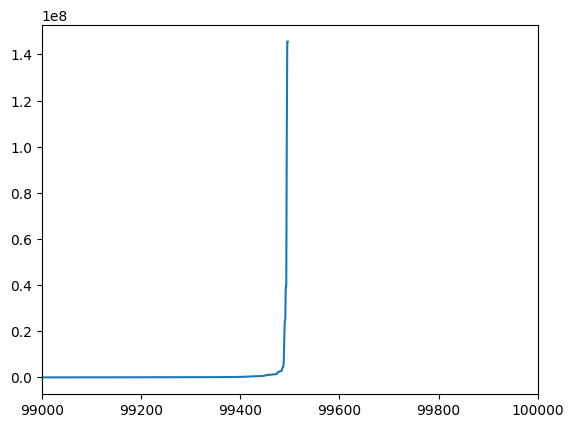

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
indices

array([[    0, 21797, 38852, ..., 58616,  2328, 91662],
       [    1, 58677,  9644, ..., 86577, 47733, 74570],
       [    2,  2529, 55514, ..., 59013, 18158, 56420],
       ...,
       [99493, 75472, 72918, ..., 58152, 10774, 98654],
       [99494, 12913, 56936, ..., 74413,  5045, 37051],
       [99495, 45103, 71076, ..., 83293, 57774, 50083]])

### PCA 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df_sample.iloc[:,2:]
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
pca = PCA()
prin_comps = pca.fit_transform(X_scaled)

In [ ]:
sum(pca.explained_variance_ratio_[:9])

0.8187769193108515

In [ ]:
PCA_transf_df = pd.DataFrame(prin_comps).iloc[:,:9]

### DBSCAN on PCA-ed Data

In [ ]:
PCA_transf_df

0         1         2         3         4         5         6  \
0     -0.004989  0.628590 -2.351338 -0.767830  1.356518 -0.768400  0.062178   
1      0.015856  0.689787 -3.440587  0.632946 -3.038540  1.332626 -0.915628   
2     -0.011515  0.172223 -1.138180  0.252448 -1.434464  0.388354  0.389863   
3      0.021388  0.901126 -2.021522  1.568124 -4.346595 -0.272014 -1.085411   
4     -0.048265 -0.234819 -0.082598 -0.466000  0.653015 -0.910933 -0.288447   
...         ...       ...       ...       ...       ...       ...       ...   
99492 -0.094020 -0.875386  1.606481  0.101995  0.165797  0.534544 -0.366038   
99493 -0.100393 -0.834126  1.630640 -0.044964  0.049178  1.672158  1.098669   
99494 -0.015668  0.285274 -1.266894 -0.927756  1.023130  0.436843 -0.066203   
99495 -0.057090 -0.472280  0.718472 -0.074891  0.510336  0.127684 -0.572770   
99496  0.002868  0.233824 -0.429933 -0.539627  0.307134 -0.587640 -0.142790   

              7         8  
0     -0.814646  0.336844  
1     -2.258845  0.412471  
2     -0.814772 -0.021438  
3     -4.516054  0.214627  
4     -0.219961  0.123527  
...         ...       ...  
99492 -0.036414 -0.031448  
99493  0.391273 -0.026332  
99494  0.670612 -0.976117  
99495 -0.120371  0.042128  
99496 -0.082480  0.077307  

[99497 rows x 9 columns]

In [ ]:
neigh = NearestNeighbors(n_neighbors = 50)
nbrs = neigh.fit(PCA_transf_df)

In [ ]:
distances, indices = nbrs.kneighbors(PCA_transf_df)

In [ ]:
distances = np.sort(distances,axis = 0)

(99000.0, 100000.0)

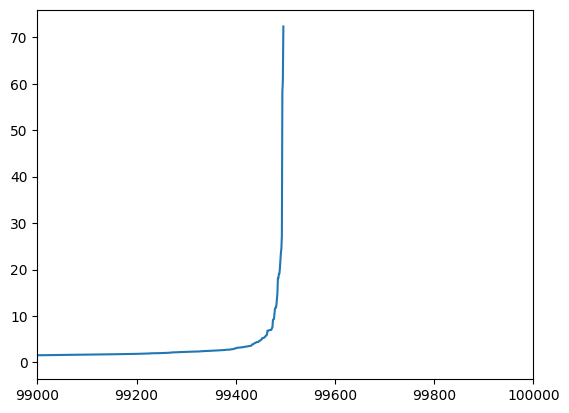

In [ ]:
plt.plot(distances[:,1])
plt.xlim(99000, 100000)

In [ ]:
DBS_clustering = DBSCAN(eps = 10, min_samples = 50)

In [ ]:
DBS_clustering.fit(PCA_)

NameError: name 'PCA_' is not defined

### K-Means

In [ ]:
data = p